# Part I. EDA 

## Some first comments and info 

Different data queries have been done, including: 
- Different time frames (1/3/6/12 months)
- Different features' sets 
- Hour and Minute information 

With the information extracted from those queries, it was concluded that: 
- We will work with 12 months worth of data (a whole year). Working with 2 years worth of data (2020-2021) is not possible because Google Analytics "just" stores the cookies (clientID) data for a period of 2 years. This period can get extended for another 2 years every time that a clientID visit the website again. However, we cannot just assume that all visitors will visit a website for a second time in a 2 year period. Therefore, just one year was selected. Other features (like age, gender) are deleted after 6 months (not sure where I read this, check!)
- Also, this is an observation study - in other words, we did not set any kind of special promotion or advertisement and just observed the data that already existed. This brings challenges like 
    - Working with data from periods that have been considerably good/better for donations ("Covid times"). Not sure if official references exist in this regard 
    - Working with data that includes "special" days for donations, like #GivingTuesday 
    - Working with data from external (new) and also internal (already donors) users. Internal users tend to react better (i.e. they receive and emails and therefore have the change to react to them)
    - Some visits to the website are done to the Karriere Portal 
- We will import a basic feature set. Many features exist in google, although many of them seem to be empty (like age, gender, campaign info).
- Importing not just the date, but also hour + minute of the visit created a big redundancy in the dataset. The reason was that pagevisits (and maybe other related features like hits, events, etc) are shown per minute. On the other hand, the total time spent in website in one session is just shown on the first row for a clientID. We decided to import date + hour, just to extract "time of start" of the website visit. The original idea was taking into account those visitors with several visits on the same day and through the same channel, but I think building up such table is too complex for the (probably) limited number of cases that will exist. 

In [1012]:
import warnings 
import requests
import urllib.parse as up
import json
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import constants_year_MT 
import importlib # to reload the constants module. Necessary if we do changes in module. See https://stackoverflow.com/questions/33323707/how-do-i-reload-a-module-after-changing-it 
import statistics 
import seaborn as sns 

## Getting data 

Data from: 
- Supermetrics, which access Google Analytics data. Stores data of website traffic, for a max. period of 2 years 
- Internal relational database, accessed by sql code


### Data from Supermetrics - all

Code based on Supermetrics tutorial to query data into python: https://supermetrics.com/blog/how-to-load-data-into-mysql

Urls are stored in a constants file ('constants_MT.py'). For data privacy reasons, that file will not be pushed into the repo. Therefore, reproducibility of this analysis cannot be assured. Urls contain the supermetrics queries for different timeframes in 2021. At first, just some basic features are imported, including clientID, transaction yes/no, transaction amount and marketing channel used to access the website. Since tables from supermetric queries have a maximum size of 1.000.000 rows, two tables may be needed (depending on the query)

After some trials with different time frames, I finally decided to work with 12 months (01.01.2021 - 31.12.2021)

Steps to import data from supermetrics: 

* Import urls from constant file
* Call API 
* Check response - response needs to be 200 to be successfull; 500 indicates error

In [1013]:
# import basic table containing time data 
importlib.reload(constants_year_MT)
from constants_year_MT import url_12months_complete_time_til_june
response_basic_june = requests.get(url_12months_complete_time_til_june)
print(response_basic_june)

from constants_year_MT import url_12months_complete_time_til_dec
response_basic_dec = requests.get(url_12months_complete_time_til_dec)
print(response_basic_dec)


<Response [200]>
<Response [200]>


In [1014]:
# function to create dataframe from url data 
def url_to_df (url, response): 
    """
    Function to create pandas dataframe from url data. Imported data needs 
    to be of type json or keyjson. Otherwise an exception error is thrown

    Arguments: 
        url: url previously imported from constants file 
        response: previously extracted response 

    Returns: 
        df2: supermetrics information transformed into pandas dataframe 
    """

    if 'data/json?' in url:
        # convert json into pandas df 
        data = json.loads(json.dumps(response.json()))
        df = pd.DataFrame.from_dict(data['data'])
        headers = df.iloc[0]
        df2 = pd.DataFrame(df.values[1:], columns=headers)
    elif 'data/keyjson?' in url:
        # convert json key-value pair output to pandas df 
        df2 = pd.read_json(json.dumps(response.json()))
    else:
        # throw exception message 
        import sys
        sys.exit("DEFINE JSON OR KEYJSON AS OUTPUT FORMAT: https://supermetrics.com/docs/product-api-output-formats/")
    return df2     

In [1015]:
df_basic1 = url_to_df(url_12months_complete_time_til_june, response_basic_june)
df_basic2 = url_to_df(url_12months_complete_time_til_dec, response_basic_dec)

# concatenate tables 
frames = [df_basic1, df_basic2]
df_basic = pd.concat(frames)

Some pretreatment is needed - class change of certain features. Also, Hour and Minute will be combined to create a timestamp of the visit/transaction. In multi-channel attribution modelling, *transactions* are also known as *conversions*. 

In [1016]:
# select table to work with 
df = df_basic
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1015525 entries, 0 to 452058
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   clientID             1015525 non-null  object
 1   Date                 1015525 non-null  object
 2   Hour                 1015525 non-null  object
 3   Minute               1015525 non-null  object
 4   Source               1015525 non-null  object
 5   Medium               1015525 non-null  object
 6   Channel group        1015525 non-null  object
 7   Operating system     1015525 non-null  object
 8   Users                1015525 non-null  object
 9   Transactions         1015525 non-null  object
 10  Transaction revenue  1015525 non-null  object
 11  Pageviews            1015525 non-null  object
 12  Total time on site   1015525 non-null  object
dtypes: object(13)
memory usage: 108.5+ MB


### Internal data 

- Internal data extracted from FRNow using SQL. It just contains data related to transactions done on the website from 01.01.2021
- Data was stored as csv and imported here. For privacy reasons, csv file cannot be find on the repo
- Internal data also needs certain pretreatment
- Data will be then joined with the transactional data from Supermetrics to carry out some analysis

In [1017]:
df_transactions_frnow = pd.read_csv(r'C:\Users\carol\OneDrive\Escritorio\FH Kufstein\MT\analysis\transaction_table_v3.csv', sep = ";", encoding = "ISO-8859-1")
df_transactions_frnow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10308 entries, 0 to 10307
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   transaction_id     10308 non-null  object 
 1   contact_number     10308 non-null  int64  
 2   reference_type     10308 non-null  object 
 3   campaign_activity  10308 non-null  object 
 4   lts                10230 non-null  object 
 5   startdate          10308 non-null  object 
 6   gender             10308 non-null  object 
 7   age                8615 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 644.4+ KB


### Data from Supermetrics - transactions

- As already mentioned, internal data needs to be joined to data extacted from Supermetrics, i.e. data from transactions
- An inconsistency was found while querying data from Supermetrics: the results differ depending on the data range considered. To avoid that inconsistency, 2 tables were again queried, as we did to query all data (see "Data from Supermetrics - all")

In [1018]:
warnings.filterwarnings('ignore')
importlib.reload(constants_year_MT)
from constants_year_MT import url_transaction_table_til_june, url_transaction_table_til_dec 
response_transactions_til_june = requests.get(url_transaction_table_til_june)
response_transactions_til_dec= requests.get(url_transaction_table_til_dec)
print(response_transactions_til_june)
print(response_transactions_til_dec)

# create df using previous function 
df_transactions_supermetrics1 = url_to_df(url_transaction_table_til_june, response_transactions_til_june)
df_transactions_supermetrics2 = url_to_df(url_transaction_table_til_dec,response_transactions_til_dec)

<Response [200]>
<Response [200]>


In [1309]:
# concatenate tables 
frames = [df_transactions_supermetrics1, df_transactions_supermetrics2]
df_transactions_supermetrics = pd.concat(frames)

In [1310]:
# check that number of transactions agrees with the one from the complete dataset  
df_transactions_supermetrics['Transactions'].sum()

8072

## Data pretreatment

Data pretreatment needed for: 

- EDA analysis. Focus on visits (touchpoints)
- Attribution models. Focus on paths (sets of touchpoints at user level)

### Data pretreatment for EDA 

* Create time feature combining hour + minute
* Drop redundant features 
* Transform data into correct format 
* Reorder columns and table using clientID, Date and Time 
* Extract time of start and time of end of visit and drop redundancy in dataset (start and end time are features and as such do not create row-redundancy). They will have an effect on path_order
* Create features: 
    * `path_order` - it indicates the touchpoint (visit) number of each visitor
    * `new_old_client_in_2021` - it indicates if the donor has one or more visits in 2021

In [1021]:
df.clientID.nunique()

341813

In [1022]:
# combine hour + minute to create timestamp. Drop those features 
df['Time'] = (pd.to_datetime(df['Hour'].astype(str) + ':' + df['Minute'].astype(str), format='%H:%M').dt.time)
df.drop('Hour', axis = 1, inplace = True)
df.drop('Minute', axis = 1, inplace = True)

In [1023]:
# function to convert data to correct format
def transform_class (df, feats_to_convert):
    for f in feats_to_convert: 
        if f in ['Date', 'Time']:
            df[f] = pd.to_datetime(df[f])
        #elif f == 'Time': 
        #    df[f] = pd.to_datetime(df[f], format='%H:%M:%S')
        else: # all others are numeric 
            df[f] = pd.to_numeric(df[f], errors = 'coerce')
    return df

In [1024]:
feats_to_convert = ['Date', 'Transactions', 'Transaction revenue', 'Pageviews', 'Total time on site', 'Users']
df = transform_class(df, feats_to_convert)

In [1025]:
# reorder columns 
df = df[['clientID', 'Date', 'Time', 'Transactions', 'Transaction revenue', 'Channel group', 'Operating system', 'Source', 'Medium', 'Total time on site', 'Pageviews', 'Users']]

# reorder table by clientID, Date and Time 
df = df.sort_values(['clientID', 'Date', 'Time'])

# check number of unique clientIDs 
# print('Number of unique visitor identifiers: ', df['clientID'].nunique())

In [1026]:
# extract information about first time with total time on site (which can be found on first row) + last time + rename columns 
df_firsttime = df.groupby(['clientID', 'Date', 'Channel group'], as_index = False)['Time'].first()
df_firsttime.rename(columns = {'Time':'time_start'}, inplace = True)
df_lasttime = df.groupby(['clientID', 'Date', 'Channel group'], as_index = False)['Time'].last()
df_lasttime.rename(columns = {'Time':'time_end'}, inplace = True)

In [1027]:
# 'outer' keeps both, merge on all feats to avoid redundancy in merged dataset 
df_first_and_last = pd.merge(left = df_firsttime, right = df_lasttime, how = 'outer', on = ['clientID', 'Date', 'Channel group'])
df_first_and_last = df_first_and_last.drop_duplicates() # those where Time (First) and time (last) are the same 
df_first_and_last.head()

,clientID,Date,Channel group,time_start,time_end
0,1000005671.1568444004,2021-01-04,Display,22:30:00,22:30:00
1,1000006728.1622927843,2021-06-05,Direct,23:17:00,23:17:00
2,1000020259.1556972396,2021-01-31,Referral,19:57:00,19:57:00
3,1000023369.1635190743,2021-10-25,Referral,21:39:00,21:39:00
4,1000024791.1630470945,2021-09-01,Branded Paid Search,06:35:00,06:36:00


In [1028]:
# transform date + time into timestamp. Takes a while 
df_first_and_last['timestamp_start'] = pd.to_datetime(df_first_and_last.Date.apply(str) + ' ' + df_first_and_last.time_start.apply(str))
df_first_and_last['timestamp_end'] = pd.to_datetime(df_first_and_last.Date.apply(str) + ' ' + df_first_and_last.time_end.apply(str))

# calculate difference between both timestamps - in minutes. It should anyway agree with time spend on site 
df_first_and_last['timestamp_diff'] = (df_first_and_last['timestamp_end'] - df_first_and_last['timestamp_start']).astype('timedelta64[m]')

In [1029]:
# re-calculate total time on site and pageviews - sum per clientID and date 
new_df = df 
new_df = new_df.groupby(['clientID', 'Date', 'Channel group', 'Operating system', 'Source','Medium']).sum()
new_df = new_df.reset_index()

# merge with original dataset, keeping rows from df_first_and_last 
df_final = pd.merge(left = new_df, right = df_first_and_last, how = 'left', on = ['clientID', 'Date', 'Channel group'])
df_final.head() 

,clientID,Date,Channel group,Operating system,Source,Medium,Transactions,Transaction revenue,Total time on site,Pageviews,Users,time_start,time_end,timestamp_start,timestamp_end,timestamp_diff
0,1000005671.1568444004,2021-01-04,Display,Android,google,cpc,0,0.0,0,1,1,22:30:00,22:30:00,2021-01-04 22:30:00,2021-01-04 22:30:00,0.0
1,1000006728.1622927843,2021-06-05,Direct,iOS,(direct),(none),0,0.0,0,1,1,23:17:00,23:17:00,2021-06-05 23:17:00,2021-06-05 23:17:00,0.0
2,1000020259.1556972396,2021-01-31,Referral,Android,trafficbot.life,referral,0,0.0,0,1,1,19:57:00,19:57:00,2021-01-31 19:57:00,2021-01-31 19:57:00,0.0
3,1000023369.1635190743,2021-10-25,Referral,Android,sos-kinderdorf.bewerberportal.at,referral,0,0.0,0,1,1,21:39:00,21:39:00,2021-10-25 21:39:00,2021-10-25 21:39:00,0.0
4,1000024791.1630470945,2021-09-01,Branded Paid Search,iOS,google,cpc,0,0.0,38,2,2,06:35:00,06:36:00,2021-09-01 06:35:00,2021-09-01 06:36:00,1.0


In [1030]:
# create path order per clientID and date 
df_final['path_order'] = df_final.groupby('clientID').cumcount() + 1
df_final['path_order_by_date'] = df_final.groupby(['clientID', 'Date']).cumcount() + 1

In [1031]:
# create feature of new/old client in 2021
## new => path_order = 1
## old => path_order > 1
df_final['type_of_client_by_path_order'] = (df_final.path_order > 1).astype('int')
# change categories 
df_final.type_of_client_by_path_order[df_final.type_of_client_by_path_order == 1] = 'old_by_path_order'
df_final.type_of_client_by_path_order[df_final.type_of_client_by_path_order == 0] = 'new_by_path_order'

# check result 
# df_final.value_counts(['path_order', 'type_of_client_by_path_order'])

In [1032]:
df_final[df_final['path_order'] > 1]
# check specific case 
df_final[df_final['clientID'] == '1000102684.1614848502']

,clientID,Date,Channel group,Operating system,Source,Medium,Transactions,Transaction revenue,Total time on site,Pageviews,Users,time_start,time_end,timestamp_start,timestamp_end,timestamp_diff,path_order,path_order_by_date,type_of_client_by_path_order
20,1000102684.1614848502,2021-03-04,Generic Paid Search,Windows,google,cpc,0,0.0,8,1,1,10:01:00,10:01:00,2021-03-04 10:01:00,2021-03-04 10:01:00,0.0,1,1,new_by_path_order
21,1000102684.1614848502,2021-12-21,Display,Windows,google,cpc,0,0.0,0,1,1,15:29:00,15:29:00,2021-12-21 15:29:00,2021-12-21 15:29:00,0.0,2,1,old_by_path_order


`new_old_client` contains one row per clientID, indicating if clientID appears once ("new_in_2021") or more often ("old_in_2021") in the dataset

In [1033]:
# create feature of new/old client - grouping information + merge with original dataset 
new_old_client = df_final[['clientID', 'Date', 'path_order']]
new_old_client = new_old_client.sort_values(['clientID', 'path_order'])
# just keep last one 
new_old_client = new_old_client.drop_duplicates('clientID', keep = 'last')
new_old_client['general_type_of_client'] = (new_old_client.path_order > 1).astype('int')
# change name of categories 
new_old_client.general_type_of_client[new_old_client.general_type_of_client == 1] = 'old_in_2021'
new_old_client.general_type_of_client[new_old_client.general_type_of_client == 0] = 'new_in_2021'

# drop features not needed - all except clientID and general_type_of_client 
new_old_client.drop(['Date', 'path_order'], axis = 1, inplace = True)
# new_old_client

In [1034]:
df_final.clientID.nunique()

341813

In [1035]:
# merge with original table using clientID to have new_old_client feature available 
df_original = pd.merge(df_final, new_old_client, how = 'left', on = ('clientID'))
df_original.head()
print('Original number of transactions: ')
df_original.Transactions.sum()

Original number of transactions: 


8072

In [1311]:
# check and drop missing data - no missing data found 
print(df_original.isna().sum()) 
# df_original = df_original.dropna()

0
clientID                        0
Date                            0
Channel group                   0
Operating system                0
Source                          0
Medium                          0
Transactions                    0
Transaction revenue             0
Total time on site              0
Pageviews                       0
Users                           0
time_start                      0
time_end                        0
timestamp_start                 0
timestamp_end                   0
timestamp_diff                  0
path_order                      0
path_order_by_date              0
type_of_client_by_path_order    0
general_type_of_client          0
dtype: int64


(!) Attention! we know that 2 entry errors exist in transaction revenue, see analysis of internal data. We have imputed the real values to those, before we keep on doing the analysis 

In [1037]:
df_original.loc[df_original.clientID == '676908493.1607510701', 'Transaction revenue'] = 600
df_original.loc[df_original.clientID == '97296655.1614192922', 'Transaction revenue'] = 210

We got to realise that some visits were done through a Bewerberportal (source). We checked if some transactions were also done: 
* No single transaction for one-time visit 
* 0.18% of transactions for the more-times visit 

We decided to drop those visitors 

In [1038]:
# grouped df per client - to extract one vs more visits 
grouped_df_original_per_clientID = df_original[['clientID']].groupby('clientID').value_counts()
grouped_df_original_per_clientID = grouped_df_original_per_clientID.to_frame()
# create feature of new_vs_old_visitor_in_2021 
grouped_df_original_per_clientID['one_vs_more_times_visitor'] = np.where(grouped_df_original_per_clientID > 1, "more_times", "once")
grouped_df_original_per_clientID['one_vs_more_times_visitor'].value_counts()

once          277980
more_times     63833
Name: one_vs_more_times_visitor, dtype: int64

In [1039]:
# extract users with just one visit
users_one_visit = grouped_df_original_per_clientID[grouped_df_original_per_clientID['one_vs_more_times_visitor'] == 'once']
users_one_visit.index.name = 'clientID'
users_one_visit.reset_index(inplace=True)

# extract users with more than one visit 
users_more_visits = grouped_df_original_per_clientID[grouped_df_original_per_clientID['one_vs_more_times_visitor'] == 'more_times']
users_more_visits.index.name = 'clientID'
users_more_visits.reset_index(inplace=True)

df_one_visit = df_original[df_original['clientID'].isin(users_one_visit['clientID'])]
df_more_visits = df_original[df_original['clientID'].isin(users_more_visits['clientID'])]


In [1040]:
#special case: source sos-kinderdorf.bewerberportal.at'
print('Number of visitors to Bewerberportal with one visit: ', len(df_one_visit[df_one_visit['Source'] == 'sos-kinderdorf.bewerberportal.at']))
print('Transactions from Bewerber in one-time visitor: ', df_one_visit[df_one_visit['Source'] == 'sos-kinderdorf.bewerberportal.at'].Transactions.sum()) 
print('Number of visitors to Bewerberportal with more than one visit: ', len(df_more_visits[df_more_visits['Source'] == 'sos-kinderdorf.bewerberportal.at']))
print('Transactions from Bewerber in more-times visitor: ', df_more_visits[df_more_visits['Source'] == 'sos-kinderdorf.bewerberportal.at'].Transactions.sum()) 

Number of visitors to Bewerberportal with one visit:  1354
Transactions from Bewerber in one-time visitor:  0
Number of visitors to Bewerberportal with more than one visit:  10630
Transactions from Bewerber in more-times visitor:  20


In [1041]:
# drop those website visitors 
karriere1 = df_one_visit[df_one_visit['Source'] == 'sos-kinderdorf.bewerberportal.at']['clientID']
karriere2 = df_more_visits[df_more_visits['Source'] == 'sos-kinderdorf.bewerberportal.at']['clientID']
print('Number of unique visitors to career site, with one visit: ', karriere1.nunique())
print('Number of unique visitors to the career site, with more than one visit: ', karriere2.nunique())

Number of unique visitors to career site, with one visit:  1354
Number of unique visitors to the career site, with more than one visit:  7496


In [1042]:
df_original = df_original[-df_original['clientID'].isin(karriere1)]
df_original = df_original[-df_original['clientID'].isin(karriere2)]
print(len(df_original))
print(df_original['clientID'].nunique())

435840
332963


#### Create dataframe filtering GivingTuesday and dataframe of JUST GivingTuesday 

In EDA analysis, we also checked that conversion pattern on #GivingTuesday was too different to the rest of the year, both in terms of conversion % and conversion revenue.



In [1312]:
df_giving_tuesday = df_original[df_original['Date'] == '2021-11-30']
df_eda = df_original[df_original['Date'] != '2021-11-30']

# Imputer users = 1 per row (i.e. per website visit)
df_eda['Users'] = 1
# df_eda

In [1313]:
# df_eda.Transactions.sum()
# print(df_eda.isna().sum()) 

6535

#### Create table of grouped values - by clientID 

In [1044]:
# grouped df per client - to extract one vs more visits 
df_grouped_by_clientID = df_eda[['clientID']].groupby('clientID').value_counts()
df_grouped_by_clientID = df_grouped_by_clientID.to_frame()
# create feature of new_vs_old_visitor_in_2021 
df_grouped_by_clientID['one_vs_more_times_visitor'] = np.where(df_grouped_by_clientID > 1, "more_times", "once")
df_grouped_by_clientID['one_vs_more_times_visitor'].value_counts()
# change name of column "0" with "counts"
df_grouped_by_clientID.rename({0:'counts'}, axis = 1, inplace = True)

#### Create table of grouped values - by channel 

In [1045]:
# create table of channel + group by channel group and date 
df_channel_original = df_original[['Date', 'Channel group', 'Transactions', 'Transaction revenue', 'Total time on site', 'Pageviews']]
df_grouped_by_channel_original = df_channel_original.groupby(['Date', 'Channel group']).sum()
# add column of unique clientID count 
df_grouped_by_channel_original['number_unique_clientID'] = df_original.groupby(['Date', 'Channel group'])['clientID'].nunique().rename('unique_clientID')
# add column of total clientID count - redundancy will exist, because some users appear to access the website in consequent minutes 
df_grouped_by_channel_original['number_total_clientID'] = df_original.groupby(['Date', 'Channel group']).size().values
df_grouped_by_channel_original.head() 

0                               Transactions  Transaction revenue  \
Date       Channel group                                            
2021-01-01 (Other)                         0                  0.0   
           Branded Paid Search            16               2475.0   
           Direct                          6                710.0   
           Display                         0                  0.0   
           Email                           1                 75.0   

0                               Total time on site  Pageviews  \
Date       Channel group                                        
2021-01-01 (Other)                              68          2   
           Branded Paid Search               22802        459   
           Direct                            23242        437   
           Display                          300453       5409   
           Email                               544         21   

0                               number_unique_clientID  number_total_clientID  
Date       Channel group                                                       
2021-01-01 (Other)                                   1                      1  
           Branded Paid Search                     114                    114  
           Direct                                  151                    151  
           Display                                3784                   3784  
           Email                                     7                      7

In [1046]:
# create table of channel + group by channel group and date 
df_channel = df_eda[['Date', 'Channel group', 'Transactions', 'Transaction revenue', 'Total time on site', 'Pageviews']]
df_grouped_by_channel = df_channel.groupby(['Date', 'Channel group']).sum()
# add column of unique clientID count 
df_grouped_by_channel['number_unique_clientID'] = df_eda.groupby(['Date', 'Channel group'])['clientID'].nunique().rename('unique_clientID')
# add column of total clientID count - redundancy will exist, because some users appear to access the website in consequent minutes 
df_grouped_by_channel['number_total_clientID'] = df_eda.groupby(['Date', 'Channel group']).size().values
df_grouped_by_channel.head()

0                               Transactions  Transaction revenue  \
Date       Channel group                                            
2021-01-01 (Other)                         0                  0.0   
           Branded Paid Search            16               2475.0   
           Direct                          6                710.0   
           Display                         0                  0.0   
           Email                           1                 75.0   

0                               Total time on site  Pageviews  \
Date       Channel group                                        
2021-01-01 (Other)                              68          2   
           Branded Paid Search               22802        459   
           Direct                            23242        437   
           Display                          300453       5409   
           Email                               544         21   

0                               number_unique_clientID  number_total_clientID  
Date       Channel group                                                       
2021-01-01 (Other)                                   1                      1  
           Branded Paid Search                     114                    114  
           Direct                                  151                    151  
           Display                                3784                   3784  
           Email                                     7                      7

#### Create table of grouped values - by date

In [1047]:
# create table of grouped df - with numeric values grouped by date 
df_grouped_original = df_original[['Date', 'Transactions', 'Transaction revenue', 'Total time on site', 'Pageviews']]
df_grouped_by_date_original = df_grouped_original.groupby(['Date']).sum() 
# add column of unique clientID count 
df_grouped_by_date_original['number_unique_clientID'] = df_original.groupby('Date')['clientID'].nunique().rename('unique_clientID')
# add column of total clientID count - redundancy will exist, because some users appear to access the website in consequent minutes 
df_grouped_by_date_original['number_total_clientID'] = df_original.groupby('Date').size().values
df_grouped_by_date_original.head() 

,Transactions,Transaction revenue,Total time on site,Pageviews,number_unique_clientID,number_total_clientID
Date,,,,,,
2021-01-01,41,5864.90,414794,7847,4618,4663
2021-01-02,47,25287.00,470093,8553,4793,4862
2021-01-03,31,4047.40,433822,8847,5196,5254
2021-01-04,37,6637.00,443755,9443,5130,5223
2021-01-05,26,2845.21,500315,8524,4737,4812


In [1048]:
# create table of grouped df - with numeric values grouped by date 
df_grouped = df_eda[['Date', 'Transactions', 'Transaction revenue', 'Total time on site', 'Pageviews']]
df_grouped_by_date = df_grouped.groupby(['Date']).sum() 
# add column of unique clientID count 
df_grouped_by_date['number_unique_clientID'] = df_eda.groupby('Date')['clientID'].nunique().rename('unique_clientID')
# add column of total clientID count - redundancy will exist, because some users appear to access the website in consequent minutes 
df_grouped_by_date['number_total_clientID'] = df_eda.groupby('Date').size().values
df_grouped_by_date.head()

,Transactions,Transaction revenue,Total time on site,Pageviews,number_unique_clientID,number_total_clientID
Date,,,,,,
2021-01-01,41,5864.90,414794,7847,4618,4663
2021-01-02,47,25287.00,470093,8553,4793,4862
2021-01-03,31,4047.40,433822,8847,5196,5254
2021-01-04,37,6637.00,443755,9443,5130,5223
2021-01-05,26,2845.21,500315,8524,4737,4812


### Data pretreatment for attribution modelling 

For attribution modelling we need to: 
* Split customer paths into chunks, to represent "path until reaction". Because users may react more than once, we should split the touchpoints on a clientID level, creating "paths until reaction"
* Create table of paths with specific structure - necessary to work with attribution modelling package 

In [1259]:
# reorder table by clientID, Date and time_start 
df_eda = df_eda.sort_values(['clientID', 'timestamp_start'])
df_eda.head()

,clientID,Date,Channel group,Operating system,Source,Medium,Transactions,Transaction revenue,Total time on site,Pageviews,Users,time_start,time_end,timestamp_start,timestamp_end,timestamp_diff,path_order,path_order_by_date,type_of_client_by_path_order,general_type_of_client
0,1000005671.1568444004,2021-01-04,Display,Android,google,cpc,0,0.0,0,1,1,22:30:00,22:30:00,2021-01-04 22:30:00,2021-01-04 22:30:00,0.0,1,1,new_by_path_order,new_in_2021
1,1000006728.1622927843,2021-06-05,Direct,iOS,(direct),(none),0,0.0,0,1,1,23:17:00,23:17:00,2021-06-05 23:17:00,2021-06-05 23:17:00,0.0,1,1,new_by_path_order,new_in_2021
2,1000020259.1556972396,2021-01-31,Referral,Android,trafficbot.life,referral,0,0.0,0,1,1,19:57:00,19:57:00,2021-01-31 19:57:00,2021-01-31 19:57:00,0.0,1,1,new_by_path_order,new_in_2021
4,1000024791.1630470945,2021-09-01,Branded Paid Search,iOS,google,cpc,0,0.0,38,2,1,06:35:00,06:36:00,2021-09-01 06:35:00,2021-09-01 06:36:00,1.0,1,1,new_by_path_order,new_in_2021
5,1000025674.1610314739,2021-01-10,Organic Search,Windows,google,organic,0,0.0,0,1,1,22:38:00,22:40:00,2021-01-10 22:38:00,2021-01-10 22:40:00,2.0,1,1,new_by_path_order,new_in_2021


Create path_counter, representing the number of path for those cases with at least one transaction and at least > 1 touchpoint. Possible cases include: 
* Transactions = 1 & path_order = 1 -> path_counter = 1 
* Transactions = 0 & path_order = 1 -> path_counter = 1 
* Transactions = 0 & path_order > 1 -> path_counter = 1 
* Transactions >= 1 & path_order > 1 ->  path_counter >= 1 

I wrote a loop that would assign the path_counter to each clientID in the table. However, since the number of transactions is low and the process was too slow, I finally decided to apply the loop to just the "really" necessary cases (those with path_counter >= 1) + merge results with the rest (which just have a single path)

In [1050]:
# Apply to dataset with transactions and more than one channel group. Otherwise the loop takes too long 
df_sub = df_eda[(df_eda['Transactions'] > 0) & (df_eda['path_order'] > 1)]
client_list = df_sub['clientID'].unique()
print(len(client_list))

# extract reduced dataset of clients in client_list
client_df_original = df_eda[df_eda['clientID'].isin(client_list)]

path_counter = []

for client in client_list: 
    # reset path number 
    path_number = 1
    # extract data 
    client_df = client_df_original[client_df_original['clientID'] == client]
    # sort table 
    client_df = client_df.sort_values(['clientID', 'timestamp_start', 'timestamp_end'])
    #print(client_df)
    if len(client_df) == 1: # nvm if Transaction = 0 or > 0
        # path_number = 1
        path_counter.append(path_number)
    else: # len > 1 
        for i in range(0,len(client_df)): 
            if client_df.iloc[i]['Transactions'] == 0: 
                # keep same path_counter 
                path_number = path_number
                path_counter.append(path_number)
            else: # if transaction exist 
                # keep same path counter but update it afterwards 
                path_counter.append(path_number)
                path_number += 1

1072


In [1051]:
# add path_counter into client_df_original 
client_df_original['path_counter'] = path_counter

# create table sub_df2 with clients without any transaction or with transaction but with path_order = 1 (just one touchpoint)
sub_df2 = df_eda[df_eda.clientID.isin(client_list) == False]
sub_df2['path_counter'] = 1

# concatenate both data tables 
df_merge = [sub_df2, client_df_original]
df_merge = pd.concat(df_merge) 


In [1052]:
# add info about number of touchpoints per path 
test1 = df_merge.groupby(['clientID', 'path_counter'])['clientID'].count() 
test1 = test1.to_frame()
test1.rename({'clientID':'touchpoints_number'}, axis = 1, inplace = True)
test1 = test1.reset_index()

# add into df_merge 
df_merge = pd.merge(left = df_merge, right = test1, how = 'left', on = ['clientID', 'path_counter'])

In [1053]:
# order by timestamps 
df_merge = df_merge.sort_values(['clientID', 'timestamp_start', 'timestamp_end'])
df_merge.head() 

,clientID,Date,Channel group,Operating system,Source,Medium,Transactions,Transaction revenue,Total time on site,Pageviews,...,time_end,timestamp_start,timestamp_end,timestamp_diff,path_order,path_order_by_date,type_of_client_by_path_order,general_type_of_client,path_counter,touchpoints_number
0,1000005671.1568444004,2021-01-04,Display,Android,google,cpc,0,0.0,0,1,...,22:30:00,2021-01-04 22:30:00,2021-01-04 22:30:00,0.0,1,1,new_by_path_order,new_in_2021,1,1
1,1000006728.1622927843,2021-06-05,Direct,iOS,(direct),(none),0,0.0,0,1,...,23:17:00,2021-06-05 23:17:00,2021-06-05 23:17:00,0.0,1,1,new_by_path_order,new_in_2021,1,1
2,1000020259.1556972396,2021-01-31,Referral,Android,trafficbot.life,referral,0,0.0,0,1,...,19:57:00,2021-01-31 19:57:00,2021-01-31 19:57:00,0.0,1,1,new_by_path_order,new_in_2021,1,1
3,1000024791.1630470945,2021-09-01,Branded Paid Search,iOS,google,cpc,0,0.0,38,2,...,06:36:00,2021-09-01 06:35:00,2021-09-01 06:36:00,1.0,1,1,new_by_path_order,new_in_2021,1,1
4,1000025674.1610314739,2021-01-10,Organic Search,Windows,google,organic,0,0.0,0,1,...,22:40:00,2021-01-10 22:38:00,2021-01-10 22:40:00,2.0,1,1,new_by_path_order,new_in_2021,1,1


In [1054]:
# extract date_month of Date 
df_conversions = df_merge[df_merge['Transactions'] > 0]
df_conversions['Date_month'] = df_conversions['Date'].dt.month
df_conversions = df_conversions[['Date_month', 'Transactions', 'touchpoints_number']]
# df_conversions

**Check** 

After a more thorough check of literature, I saw that different time frames were considered: 
- 30 days seems to be typical for e-commerce. It also seems to be typical to work with a "reference point in time", i.e. time when a marketing campaign is launched + 30 days afterwards, to check if visits end up in a conversion during those 30 days, or in non-conversion 
- Other sources do not really mention any kind of method, just a time frame up to 15 months 

In our case, working with whole year 2020 was not possible because cookies are just stored for a maximum period of 2 years in Google Analytics. Therefore, I considered to work with second half of 2021 (6 months) and re-construct a path of the six months before. In other words, I considered working with six months worth of data - six months until conversion or until the end of the year (for paths with no conversion). After doing some checks, I finally discarded this option, because I would lose too many paths and because no big differneces seem to exist between paths, for instance in terms of number of touchpoints per path for those two approaches. 

In particular, what I checked was: 
Are there differences in touchpoints_number depending on the month of the transaction? Do transactions done at the end of the year have more touchpoints than those done at the beginning? 

**It does not seem like the number of touchpoints have an effect on transactions patterns, month of transaction, etc**. See following plots. 

In [1055]:
grouped_df_conversions= df_conversions.groupby('Date_month')
mean_touchpoints_df = grouped_df_conversions.mean().reset_index()
median_touchpoints_df = grouped_df_conversions.median().reset_index()
quantile90_touchpoints_df = grouped_df_conversions.quantile(0.9).reset_index()

print('Results for mean touchpoints number:')
print(mean_touchpoints_df[['Date_month', 'touchpoints_number']])

Results for mean touchpoints number:
    Date_month  touchpoints_number
0            1            1.336434
1            2            1.423792
2            3            1.252907
3            4            1.331378
4            5            1.597015
5            6            1.404255
6            7            1.335196
7            8            1.743802
8            9            1.358650
9           10            1.279070
10          11            1.700000
11          12            1.339086


In [1056]:
print('Results for median touchpoints number: ') 
print(median_touchpoints_df[['Date_month', 'touchpoints_number']])

Results for median touchpoints number: 
    Date_month  touchpoints_number
0            1                 1.0
1            2                 1.0
2            3                 1.0
3            4                 1.0
4            5                 1.0
5            6                 1.0
6            7                 1.0
7            8                 1.0
8            9                 1.0
9           10                 1.0
10          11                 1.0
11          12                 1.0


In [1057]:
print('Results for 90% quantile touchpoints number: ') 
print(quantile90_touchpoints_df[['Date_month', 'touchpoints_number']])

Results for 90% quantile touchpoints number: 
    Date_month  touchpoints_number
0            1                 2.0
1            2                 2.0
2            3                 2.0
3            4                 2.0
4            5                 3.0
5            6                 2.0
6            7                 2.0
7            8                 2.0
8            9                 2.0
9           10                 2.0
10          11                 2.0
11          12                 2.0


<AxesSubplot:xlabel='Date_month'>

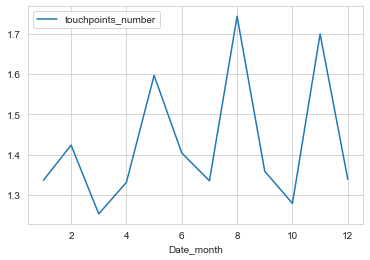

In [1058]:
# plot of results 
mean_touchpoints_df.plot(x = 'Date_month', y = 'touchpoints_number')

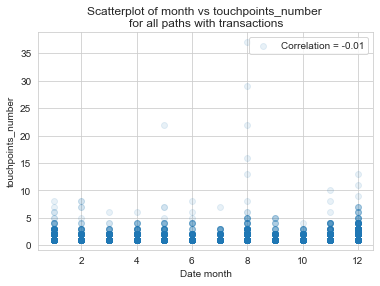

In [1059]:
# check month vs number of touchpoints 
df_conversions_clean = df_conversions[(df_conversions['touchpoints_number'] <= 50) & (df_conversions['Transactions'] <= 10)]
y = df_conversions_clean['touchpoints_number']
# y = df_conversions_clean['touchpoints_number']
x = df_conversions_clean['Date_month']

plt.scatter(x, y, label=f'Correlation = {np.round(np.corrcoef(x,y)[0,1], 2)}', alpha = 0.1)
plt.ylabel('touchpoints_number')
plt.xlabel('Date month')
plt.title('Scatterplot of month vs touchpoints_number \nfor all paths with transactions')
plt.legend()
plt.show()

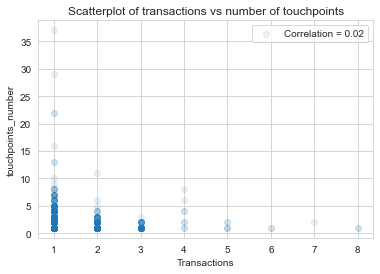

In [1060]:
# check number of touchpoints vs number of transactions 
y = df_conversions_clean['touchpoints_number']
# y = df_conversions_clean['touchpoints_number']
x = df_conversions_clean['Transactions']

plt.scatter(x, y, label=f'Correlation = {np.round(np.corrcoef(x,y)[0,1], 2)}', alpha = 0.1)
plt.ylabel('touchpoints_number')
plt.xlabel('Transactions')
plt.title('Scatterplot of transactions vs number of touchpoints')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Number of transactions per month - all')

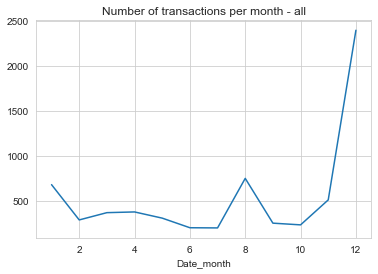

In [1061]:
# check visits (month) for those with more touchpoints 
df_conversions.groupby('Date_month')['Transactions'].sum().plot()
# plt.axhline(y = avg_original_nunique_clientids, color = 'r', linestyle = '--')
plt.title("Number of transactions per month - all")

Text(0.5, 1.0, 'Number of transactions per month - number touchpoints == 1')

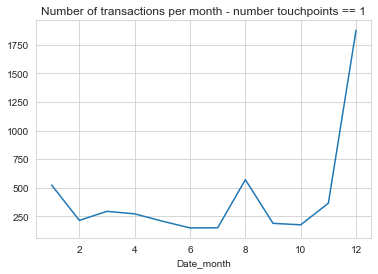

In [1062]:
df_conversions_one_touchpoint = df_conversions[df_conversions['touchpoints_number'] == 1]
df_conversions_one_touchpoint.groupby('Date_month')['Transactions'].sum().plot()
# plt.axhline(y = avg_original_nunique_clientids, color = 'r', linestyle = '--')
plt.title("Number of transactions per month - number touchpoints == 1")

Text(0.5, 1.0, 'Number of transactions per month - number touchpoints > 1')

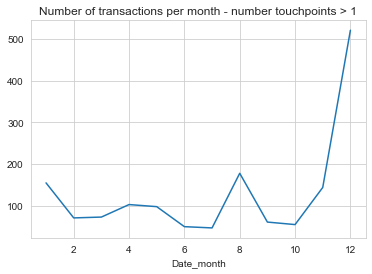

In [1063]:
df_conversions_morethanone_touchpoint = df_conversions[df_conversions['touchpoints_number'] > 1]
df_conversions_morethanone_touchpoint.groupby('Date_month')['Transactions'].sum().plot()
# plt.axhline(y = avg_original_nunique_clientids, color = 'r', linestyle = '--')
plt.title("Number of transactions per month - number touchpoints > 1")

In [1064]:
test1 = df_merge[df_merge['touchpoints_number'] > 1]
test1['Date_month'] = test1['Date'].dt.month

grouped_test = test1.groupby('Date_month')
mean_touchpoints_df = grouped_test.mean().reset_index()
median_touchpoints_df = grouped_test.median().reset_index()

print(mean_touchpoints_df[['Date_month', 'touchpoints_number']])

    Date_month  touchpoints_number
0            1            4.435171
1            2            8.699955
2            3            8.730070
3            4            8.462230
4            5            8.175315
5            6            8.146991
6            7            9.148063
7            8            8.683000
8            9            9.583853
9           10            7.421751
10          11            7.555078
11          12            5.265362


In [1065]:
print(median_touchpoints_df[['Date_month', 'touchpoints_number']])

    Date_month  touchpoints_number
0            1                 2.0
1            2                 3.0
2            3                 3.0
3            4                 3.0
4            5                 3.0
5            6                 3.0
6            7                 3.0
7            8                 3.0
8            9                 3.0
9           10                 3.0
10          11                 2.0
11          12                 2.0


In [1066]:
# check percentage of transactions done per month 
df_conversions_grouped = df_conversions.groupby('Date_month').sum().reset_index() 
df_conversions_grouped['Transactions_perc'] = df_conversions_grouped['Transactions'] / (df_conversions_grouped['Transactions'].sum())
df_conversions_grouped

,Date_month,Transactions,touchpoints_number,Transactions_perc
0,1,678,862,0.103749
1,2,285,383,0.043611
2,3,366,431,0.056006
3,4,374,454,0.057230
4,5,305,428,0.046672
5,6,198,264,0.030298
6,7,196,239,0.029992
7,8,748,1266,0.114461
8,9,249,322,0.038103
9,10,230,275,0.035195


#### Create table of paths

To model with

In [1067]:
# create df of model - grouping by clientID and path_counter 
df_model = df_merge.groupby(['clientID', 'path_counter', 'touchpoints_number']).sum().reset_index() #.sum(['Transactions', 'Transaction revenue'])
# df_model

# create df of paths 
df_paths = df_merge.groupby(['clientID', 'path_counter', 'touchpoints_number'])['Channel group'].apply(lambda x: ' > '.join(x)).reset_index()
# df_paths 

# add path information to df_model, using clientID and path_counter to join tables 
df_model = pd.merge(left = df_model, right = df_paths, how = 'left', on = ['clientID', 'path_counter', 'touchpoints_number'])
df_model.head()

,clientID,path_counter,touchpoints_number,Transactions,Transaction revenue,Total time on site,Pageviews,Users,timestamp_diff,path_order,path_order_by_date,Channel group
0,1000005671.1568444004,1,1,0,0.0,0,1,1,0.0,1,1,Display
1,1000006728.1622927843,1,1,0,0.0,0,1,1,0.0,1,1,Direct
2,1000020259.1556972396,1,1,0,0.0,0,1,1,0.0,1,1,Referral
3,1000024791.1630470945,1,1,0,0.0,38,2,1,1.0,1,1,Branded Paid Search
4,1000025674.1610314739,1,1,0,0.0,0,1,1,2.0,1,1,Organic Search


In [1068]:
# check number of touchpoints
df_model.touchpoints_number.value_counts()

1      274925
2       38296
3        9322
4        3502
5        1682
6         863
7         530
8         323
9         243
10        165
11        102
12         92
13         66
14         54
15         43
16         33
17         26
18         23
19         19
20         18
22         15
27         14
26         12
23         10
29          7
31          7
25          7
30          7
21          6
24          6
35          6
28          5
47          4
33          4
37          4
43          4
38          3
49          3
45          3
46          3
48          3
36          3
40          3
106         2
70          2
81          2
74          2
41          2
61          1
133         1
39          1
60          1
144         1
65          1
69          1
98          1
124         1
213         1
55          1
181         1
34          1
84          1
127         1
42          1
186         1
58          1
73          1
161         1
105         1
62          1
54          1
107   

In [1069]:
# create df of model - grouping by clientID and path_counter 
#df_model_withos = df_merge.groupby(['clientID', 'path_counter', 'Operating system']).sum().reset_index() #.sum(['Transactions', 'Transaction revenue'])
# df_model

# add path information to df_model, using clientID and path_counter to join tables 
#df_model_withos = pd.merge(left = df_model_withos, right = df_paths, how = 'left', on = ['clientID', 'path_counter'])
#df_model_withos

## Data under study 


* Original imported table contains 1.015.525 entries with 341.813 unique client IDs and 8.072 conversions. 
* Because of its structure, dataset contained redundancy (i.e. each hit/pageview from a session was stored in a new row in the dataset). After some pretreatment, the dataset under study contains 467.920 entries from 341.813 unique clientIDs. New, pretreated dataset also contains some more (extracted) features. 
* No rows with missing data found in the dataset. Some rows with missing data were contained on sociodemographic features on the extended table (which was finally not used)
* Visitors to the Bewerberportal filtered - no transaction for the one-time visitors and just 20 transactions (0.2%) for the more-times visitors.
* Data imported include all client IDs, i.e. those with and without transaction. As expected, the dataset is very imbalanced in terms of conversions - just 8.072 conversions for the whole year
* Data corresponds to traffic data in the website of interest, for a period of one year (01.01.2021 - 31.12.2021)

Attention! Number of transactions != number of client IDs with transactions (more than one transaction may exist)
Also, because of the dataset original structure and the pretreatment done, visits on a same day will not appear on the final dataset. 

In [1210]:
# check original, general numbers
print('Check results of original table (with redundancy)')
print('Number of rows: ', len(df)) 

Check results of original table (with redundancy)
Number of rows:  1015525


In [1211]:
print('Check results of table after preprocessing (without redundancy), original dataset. Results including #GivingTuesday')
print('Number of rows: ', len(df_original))
print('Number of columns: ', df_original.shape[1]) 
# print('Column names: ')
# print(df_eda.columns) # columns 
print('Number of unique visitor identifiers: ', df_original['clientID'].nunique())
print('Number of conversions: ', df_original['Transactions'].sum())
# print(df_eda.head())

Check results of table after preprocessing (without redundancy), original dataset. Results including #GivingTuesday
Number of rows:  435840
Number of columns:  20
Number of unique visitor identifiers:  332963
Number of conversions:  8022


In [1212]:
print('Check results of table after preprocessing (without redundancy), original dataset. Results without #GivingTuesday')
print('Number of rows: ', len(df_eda))
print('Number of columns: ', df_eda.shape[1]) 
print('Number of unique visitor identifiers: ', df_eda['clientID'].nunique())
print('Number of conversions: ', df_eda['Transactions'].sum())

Check results of table after preprocessing (without redundancy), original dataset. Results without #GivingTuesday
Number of rows:  431631
Number of columns:  20
Number of unique visitor identifiers:  329906
Number of conversions:  6535


In [1213]:
print('Check results of table of just #GivingTuesday')
print('Number of rows: ', len(df_giving_tuesday))
print('Number of unique visitor identifiers: ', df_giving_tuesday['clientID'].nunique())
print('Number of conversions: ', df_giving_tuesday['Transactions'].sum())

Check results of table of just #GivingTuesday
Number of rows:  4209
Number of unique visitor identifiers:  4034
Number of conversions:  1487


In [1214]:
print('Check results on path table')
# df_model['Transactions'].sum()
print('Total number of paths:', len(df_model))
print('Transaction rate, per path: ', round(df_model['Transactions'].sum() / len(df_model) * 100, 3))
print('Total number of unique paths: ', len(df_model.groupby('Channel group')))

Check results on path table
Total number of paths: 330506
Transaction rate, per path:  1.977
Total number of unique paths:  2594


### Check available features and levels of them 


Available features: 
* `clientID` - user identifier 
* `Date`
* `Source` - source of user (google, facebook, direct, etc)
* `Medium` - type of referrals. Directly related to `Source`
    - `utm_medium` - if manual campaign tracking 
    - `cpc` if google ads 
    - `organic` if users came from a search engine detected by google analytics 
    - `referral ` if referrer is not a search engine 
    - `(none)` (empty) if users came directly to the webpage 
* `Channel group` - where user comes from (referral, branded paid search, generic paid search, organic search)
* `Operating system`
* `Transactions, Transaction revenue` - indicate if transaction exists or not + revenue 
* `Pageviews` 
* `Total time on site` - in seconds 

## Exploratory Descriptive Analysis 


In [1075]:
avg_original_nunique_clientids = round(df_original['clientID'].nunique()/365, 2)
avg_eda_nunique_clientids = round(df_eda['clientID'].nunique()/365, 2)

### Check visit and transaction patterns

#### Focus: General trends and GivingTuesday

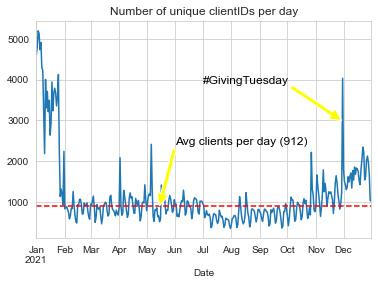

In [1076]:
# extract clients per day = sum of unique IDs per day  
# alternative i could use df_grouped_by_date['number_unique_clientID'].plot() 
df_original.groupby('Date')['clientID'].nunique().plot()
plt.axhline(y = avg_original_nunique_clientids, color = 'r', linestyle = '--')
plt.title("Number of unique clientIDs per day")
# Annotation of avg number of (unique) number of client IDs per day 
plt.annotate('Avg clients per day (912)',
              xy = ('2021-05-15', avg_original_nunique_clientids), 
              xytext =('2021-06-01', avg_original_nunique_clientids + 1500), 
              color='black',
              # fontweight='bold',
              fontsize = 12,
              arrowprops = dict(facecolor = 'yellow'))
plt.annotate('#GivingTuesday', 
             xy = ('2021-11-29', 3000), 
             xytext =('2021-07-01', avg_original_nunique_clientids + 3000), 
             color='black',
             # fontweight='bold',
             fontsize = 12,
             arrowprops = dict(facecolor = 'yellow'))
plt.show()

In [1077]:
print('General results, original dataset')
print('Number of unique clientIDs: ', df_original['clientID'].nunique())
print('Total number of rows (client IDs, new or repeated):', len(df_original))
print('Avg number of unique clientIDs per day:', round(df_original['clientID'].nunique()/365, 2))

General results, original dataset
Number of unique clientIDs:  332963
Total number of rows (client IDs, new or repeated): 435840
Avg number of unique clientIDs per day: 912.23


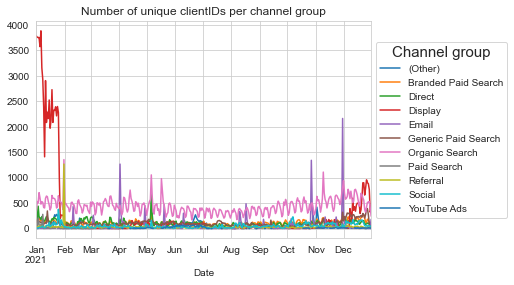

In [1078]:
df_grouped_by_channel_original.unstack()['number_unique_clientID'].plot()
plt.legend(title='Channel group',title_fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of unique clientIDs per channel group')
plt.show()

Text(2021-07-01, 1000, '#GivingTuesday')

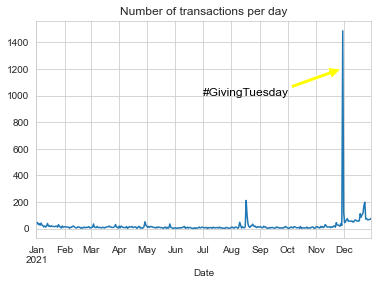

In [1079]:
# check transactions per day 
df_original.groupby('Date')['Transactions'].sum().plot()
plt.title("Number of transactions per day")
# add annotation of #givingtuesday 
plt.annotate('#GivingTuesday',
              xy = ('2021-11-28', 1200), 
              xytext =('2021-07-01',1000), 
              color='black',
              # fontweight='bold',
              fontsize = 12,
              arrowprops = dict(facecolor = 'yellow'))

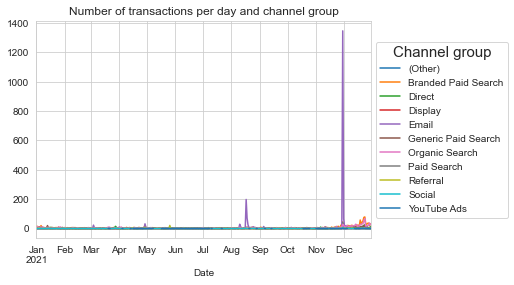

In [1080]:
df_grouped_by_channel_original.unstack()['Transactions'].plot()
plt.legend(title='Channel group',title_fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of transactions per day and channel group')
plt.show()

In [1081]:
df_transactions = df_original[df_original['Transactions'] > 0]
df_transactions_over1 = df_transactions[df_transactions['Transactions'] > 1]
total_number_transactions = df_transactions['Transactions'].sum()
total_number_transactions_over1 = df_transactions_over1['Transactions'].sum() 

print('Total number of transactions: ', total_number_transactions)
print('Avg number of transactions per day:', round(total_number_transactions/365, 2))
print('Total number of clientIDs with transactions:', len(df_transactions.clientID.value_counts()))
print('Total number of clientIDs with more than 1 transaction:', len(df_transactions_over1.clientID.value_counts()))
print('Total conversion rate: ', round(total_number_transactions / len(df_original)*100, 3), '%')
print('Total value of conversions: ', round(df_original['Transaction revenue'].sum(),3), '€')
print('Average transaction value: ', round(df_original['Transaction revenue'].sum() / total_number_transactions), '€')
print('Median transaction value: ', statistics.median(df_transactions['Transaction revenue']))
print('Max. transaction value: ', df_original['Transaction revenue'].max(), '€')
print('Min. transaction value: ', df_original[df_original['Transaction revenue'] > 0.0]['Transaction revenue'].min(), '€')

Total number of transactions:  8022
Avg number of transactions per day: 21.98
Total number of clientIDs with transactions: 6951
Total number of clientIDs with more than 1 transaction: 401
Total conversion rate:  1.841 %
Total value of conversions:  1088585.92 €
Average transaction value:  136 €
Median transaction value:  75.0
Max. transaction value:  40000.0 €
Min. transaction value:  1.0 €


In [1082]:
# check results of givingtuesday 
df_giving_tuesday = df_original[df_original['Date'] == '2021-11-30']
transactions_on_giving_tuesday = df_giving_tuesday['Transactions'].sum()
transactions_on_giving_tuesday

print('Average transaction value on GivingTuesday: ', round(df_giving_tuesday['Transaction revenue'].sum() / transactions_on_giving_tuesday), '€')
print('Median transaction value on GivingTuesday: ', statistics.median(df_giving_tuesday[df_giving_tuesday['Transaction revenue'] > 0]['Transaction revenue']), '€')
print('Max. transaction value on GivingTuesday: ', df_giving_tuesday['Transaction revenue'].max(), '€')
print('Min. transaction value on GivingTuesday: ', df_giving_tuesday[df_giving_tuesday['Transaction revenue'] > 0.0]['Transaction revenue'].min(), '€')

Average transaction value on GivingTuesday:  86 €
Median transaction value on GivingTuesday:  50.0 €
Max. transaction value on GivingTuesday:  3000.0 €
Min. transaction value on GivingTuesday:  7.5 €


Because of the results obtained, we decided to **filter the data of GivingTuesday** from the dataset. Average of unique users (clientID) per day remain almost the same. 

In [1083]:
print(avg_original_nunique_clientids)
print(avg_eda_nunique_clientids)

912.23
903.85


##### General trends without GivingTuesday

`df_eda`

In [1215]:
print('Results users: ')
print('Number of rows: ', len(df_eda))
print('Number of columns: ', df_eda.shape[1]) 
print('Number of unique visitor identifiers: ', df_eda['clientID'].nunique())
print('Number of conversions: ', df_eda['Transactions'].sum())

Results users: 
Number of rows:  431631
Number of columns:  20
Number of unique visitor identifiers:  329906
Number of conversions:  6535


In [1216]:
print('Results transactions')
df_eda_transactions = df_eda[df_eda['Transactions'] > 0]
df_eda_transactions_over1 = df_eda_transactions[df_eda_transactions['Transactions'] > 1]
df_eda_total_number_transactions = df_eda_transactions['Transactions'].sum()
df_eda_total_number_transactions_over1 = df_eda_transactions_over1['Transactions'].sum() 

print('Total number of transactions: ', df_eda_total_number_transactions)
print('Avg number of transactions per day:', round(df_eda_total_number_transactions/365, 2))
print('Total number of clientIDs with transactions:', len(df_eda_transactions.clientID.value_counts()))
print('Total number of clientIDs with more than 1 transaction:', len(df_eda_transactions_over1.clientID.value_counts()))
print('Total conversion rate: ', round(df_eda_total_number_transactions / len(df_eda)*100, 3), '%')
print('Total value of conversions: ', df_eda['Transaction revenue'].sum(), '€')
print('Average transaction value: ', round(df_eda['Transaction revenue'].sum() / df_eda_total_number_transactions), '€')
print('Median transaction value: ', statistics.median(df_eda_transactions['Transaction revenue']))
print('Max. transaction value: ', df_eda['Transaction revenue'].max(), '€')
print('Min. transaction value: ', df_eda[df_eda['Transaction revenue'] > 0.0]['Transaction revenue'].min(), '€')

Results transactions
Total number of transactions:  6535
Avg number of transactions per day: 17.9
Total number of clientIDs with transactions: 5644
Total number of clientIDs with more than 1 transaction: 335
Total conversion rate:  1.514 %
Total value of conversions:  961046.6000000001 €
Average transaction value:  147 €
Median transaction value:  75.0
Max. transaction value:  40000.0 €
Min. transaction value:  1.0 €


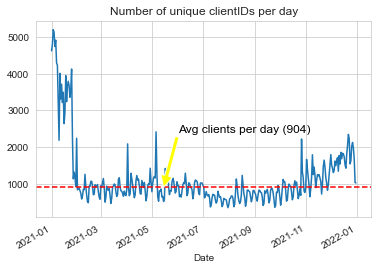

In [1217]:
# extract clients per day = sum of unique IDs per day  
## df_eda does not contain data about #GivingTuesday
df_eda.groupby('Date')['clientID'].nunique().plot()
plt.axhline(y = avg_eda_nunique_clientids, color = 'r', linestyle = '--')
plt.title("Number of unique clientIDs per day")
# Annotation of avg number of (unique) number of client IDs per day 
plt.annotate('Avg clients per day (904)',
              xy = ('2021-05-15', avg_eda_nunique_clientids), 
              xytext =('2021-06-01', avg_eda_nunique_clientids + 1500), 
              color='black',
              # fontweight='bold',
              fontsize = 12,
              arrowprops = dict(facecolor = 'yellow'))
plt.show()

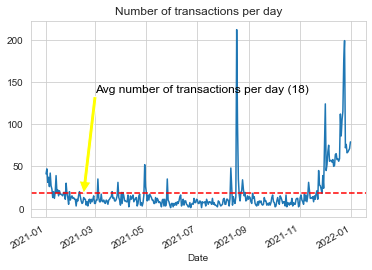

In [1218]:
# check transactions per day 
## average number of trnasactions per day = 17.9 
df_eda.groupby('Date')['Transactions'].sum().plot()
plt.axhline(y = round(df_eda_total_number_transactions/365, 2), color = 'r', linestyle = '--')
plt.title("Number of transactions per day")
plt.annotate('Avg number of transactions per day (18)',
              xy = ('2021-02-15', round(df_eda_total_number_transactions/365, 2)), 
              xytext =('2021-03-01', round(df_eda_total_number_transactions/365, 2) + 120), 
              color='black',
              # fontweight='bold',
              fontsize = 12,
              arrowprops = dict(facecolor = 'yellow'))
plt.show()

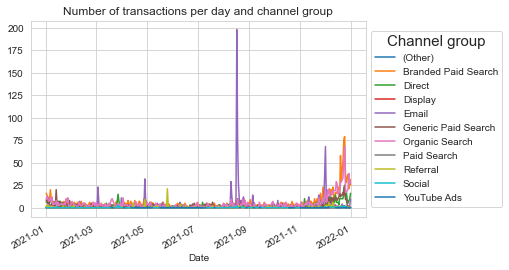

In [1088]:
df_grouped_by_channel.unstack()['Transactions'].plot()
plt.legend(title='Channel group',title_fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of transactions per day and channel group')
plt.show()

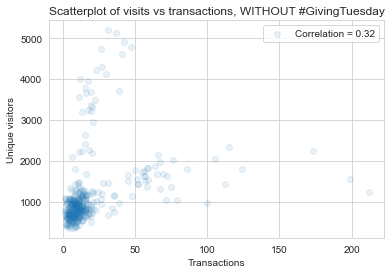

In [1089]:
# check scatterplot and correlation of number of unique visitors vs number of transactions, WITH #GivingTuesday
x = df_grouped_by_date['Transactions']
y = df_grouped_by_date['number_unique_clientID']

plt.scatter(x, y, label=f'Correlation = {np.round(np.corrcoef(x,y)[0,1], 2)}', alpha = 0.1)
plt.xlabel('Transactions')
plt.ylabel('Unique visitors')
plt.title('Scatterplot of visits vs transactions, WITHOUT #GivingTuesday')
plt.legend()
plt.show()

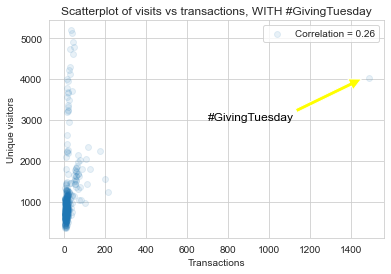

In [1090]:
# check scatterplot and correlation of number of unique visitors vs number of transactions, WITHOUT #GivingTuesday

x = df_grouped_by_date_original['Transactions']
y = df_grouped_by_date_original['number_unique_clientID']

plt.scatter(x, y, label=f'Correlation = {np.round(np.corrcoef(x,y)[0,1], 2)}', alpha = 0.1)
plt.title('Scatterplot of visits vs transactions, WITH #GivingTuesday')
plt.xlabel('Transactions')
plt.ylabel('Unique visitors')
plt.annotate('#GivingTuesday',
              xy = (1450, 4000), 
              xytext =(700, 3000), 
              color='black',
              # fontweight='bold',
              fontsize = 12,
              arrowprops = dict(facecolor = 'yellow'))
plt.legend()
plt.show()

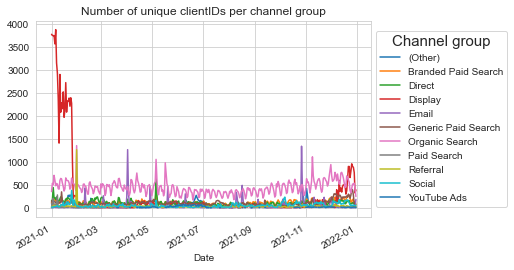

In [1091]:
# channel group vs transactions - it does not help much, the only difference is that the peak on #GivingTuesday is gone 
df_grouped_by_channel.unstack()['number_unique_clientID'].plot()
plt.legend(title='Channel group',title_fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of unique clientIDs per channel group')
plt.show()

#### Focus: One vs more-times visitor

(!) Attention! first we need to extract a table of unique users, showing if they are once or more often in the dataset. In other words, new and old should sum = number of unique users 

        index  sum visitors
0        once        274231
1  more_times         55675


Text(0.5, 1.0, 'Number of one-time vs more frequent visitors in 2021')

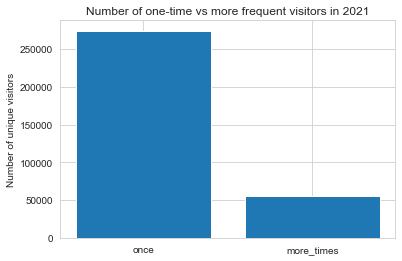

In [1092]:
test1 = df_grouped_by_clientID['one_vs_more_times_visitor'].value_counts()
test1 = test1.to_frame(name = 'sum visitors').reset_index()
print(test1)
plt.bar(test1['index'], test1['sum visitors'])
plt.ylabel('Number of unique visitors')
plt.xticks(rotation =0) 
plt.title('Number of one-time vs more frequent visitors in 2021')

Text(0.5, 1.0, 'Number of visitors vs website visits in 2021')

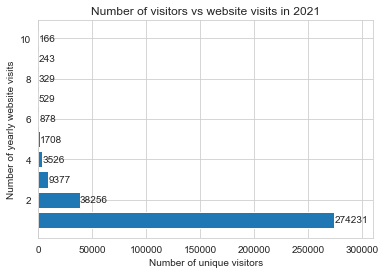

In [1093]:
y = df_grouped_by_clientID[df_grouped_by_clientID['counts'] <= 10]['counts'].value_counts()
number_range = range(1, 11)
x =[number for number in number_range]

fig, ax = plt.subplots()
bars = ax.barh(x, y)
ax.bar_label(bars)
plt.xlim([0, 310000])
plt.ylabel('Number of yearly website visits')
plt.xlabel('Number of unique visitors')
plt.title('Number of visitors vs website visits in 2021')

Are transactions done by a first-time or an "old" visitor to the website? - by literature, it should be done by "old" visitors 

`general_type_of_client` shows if clientID visited the website once or 1+ along 2021.

(!) Attention! I think the following plot should be done with the table for attribution modelling - because one client may have done a transaction at the first visit (and that indicates the end of the path)

  general_type_of_client  sum transactions
0            new_in_2021              4268
1            old_in_2021              2267


Text(0.5, 1.0, 'Number of transactions in 2021 for new vs old clients')

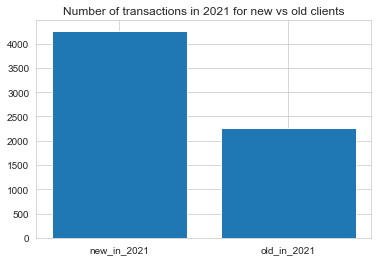

In [1094]:
# new/old vs transactions 
df_new_old_client = df_eda.groupby('general_type_of_client')['Transactions'].sum()
df_new_old_client = df_new_old_client.to_frame(name = 'sum transactions').reset_index()
print(df_new_old_client)
plt.bar(df_new_old_client['general_type_of_client'], df_new_old_client['sum transactions'])
plt.title('Number of transactions in 2021 for new vs old clients')

Check #GivingTuesday - proportion of new visitors is higher than for the normal case, see previous plot. There is potential of attraction of new donors on that day?

Text(0.5, 1.0, 'Number of transactions in 2021 for new vs old clients, #GivingTuesday')

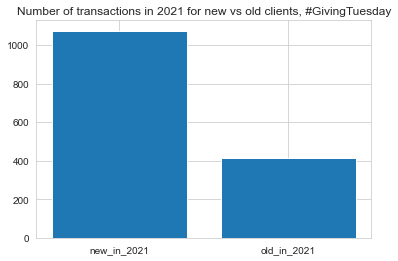

In [1095]:
df_new_old_client = df_giving_tuesday.groupby('general_type_of_client')['Transactions'].sum()
df_new_old_client = df_new_old_client.to_frame(name = 'sum transactions').reset_index()
plt.bar(df_new_old_client['general_type_of_client'], df_new_old_client['sum transactions'])
plt.title('Number of transactions in 2021 for new vs old clients, #GivingTuesday')

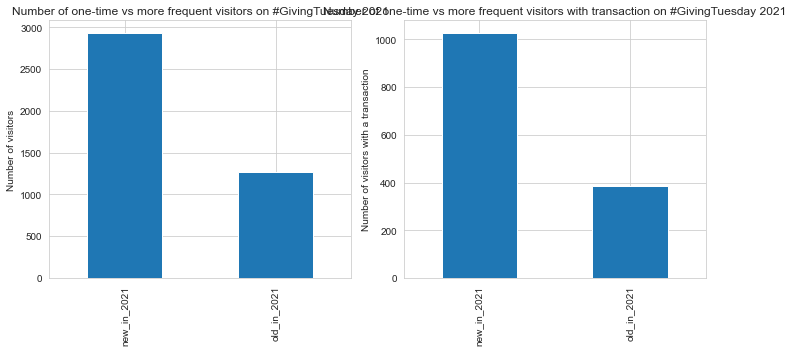

In [1096]:
# Focus - #GivingTuesday 

# change figure size 
fig = plt.figure() 
fig.set_figheight(5)
fig.set_figwidth(10)
plt.grid(False) 

plt.subplot(1,2,1)
df_giving_tuesday['general_type_of_client'].value_counts().plot(kind = 'bar')
plt.ylabel('Number of visitors')
plt.title('Number of one-time vs more frequent visitors on #GivingTuesday 2021')

plt.subplot(1, 2, 2) # row 1, col 2 index 1
df_giving_tuesday[df_giving_tuesday['Transactions'] > 0]['general_type_of_client'].value_counts().plot(kind = 'bar')
plt.ylabel('Number of visitors with a transaction')
plt.title('Number of one-time vs more frequent visitors with transaction on #GivingTuesday 2021')

# minimize overlap 
plt.tight_layout()
plt.show()

#### Focus: channel group

In [1097]:
# function to create features of interest 
def grouped_df (df, feats_to_select, feat_to_group_by, feat_to_order_table_by):
    df_grouped = df[feats_to_select].groupby(feat_to_group_by).sum() 
    df_grouped['Transactions per user'] = df_grouped['Transactions'] / df_grouped['Users']
    df_grouped['Revenue per user'] = df_grouped['Transaction revenue'] / df_grouped['Users']
    df_grouped['Revenue per transaction'] = df_grouped['Transaction revenue'] / df_grouped['Transactions']
    df_grouped['Users percentage'] = df_grouped['Users'] / df_grouped['Users'].sum()
    df_grouped['Transaction revenue percentage'] = df_grouped['Transaction revenue'] / df_grouped['Transaction revenue'].sum()
    df_grouped['Transaction percentage'] = df_grouped['Transactions'] / df_grouped['Transactions'].sum()
    # reset index - to be able to use grouping feature as feature in plot 
    df_grouped = df_grouped.reset_index() 
    # order table by feature of interest 
    df_grouped = df_grouped.sort_values(feat_to_order_table_by, ascending=True)
    return df_grouped 

feats_to_select = ['Channel group', 'Users', 'Transactions', 'Transaction revenue']
feat_to_group_by = 'Channel group'
feat_to_order_table_by = 'Transactions'
df_grouped_by_channel_general = grouped_df(df_eda, feats_to_select, feat_to_group_by, feat_to_order_table_by)
df_grouped_by_channel_general

,Channel group,Users,Transactions,Transaction revenue,Transactions per user,Revenue per user,Revenue per transaction,Users percentage,Transaction revenue percentage,Transaction percentage
7,Paid Search,1149,1,210.00,0.000870,0.182768,210.000000,0.002662,0.000219,0.000153
10,YouTube Ads,3027,3,485.00,0.000991,0.160225,161.666667,0.007013,0.000505,0.000459
0,(Other),13474,13,1631.00,0.000965,0.121048,125.461538,0.031216,0.001697,0.001989
3,Display,93972,23,2656.50,0.000245,0.028269,115.500000,0.217714,0.002764,0.003520
9,Social,18136,36,2528.00,0.001985,0.139391,70.222222,0.042017,0.002630,0.005509
8,Referral,11181,147,22365.40,0.013147,2.000304,152.145578,0.025904,0.023272,0.022494
2,Direct,39340,815,132499.62,0.020717,3.368064,162.576221,0.091143,0.137870,0.124713
4,Email,13098,874,92681.96,0.066728,7.076039,106.043432,0.030345,0.096439,0.133741
5,Generic Paid Search,36838,877,93604.88,0.023807,2.540987,106.733044,0.085346,0.097399,0.134200
6,Organic Search,159853,1690,275283.65,0.010572,1.722105,162.889734,0.370346,0.286442,0.258607


In [1098]:
print(df_grouped_by_channel_general.to_latex())

\begin{tabular}{llrrrrrrrrr}
\toprule
0 &        Channel group &   Users &  Transactions &  Transaction revenue &  Transactions per user &  Revenue per user &  Revenue per transaction &  Users percentage &  Transaction revenue percentage &  Transaction percentage \\
\midrule
7  &          Paid Search &    1149 &             1 &               210.00 &               0.000870 &          0.182768 &               210.000000 &          0.002662 &                        0.000219 &                0.000153 \\
10 &          YouTube Ads &    3027 &             3 &               485.00 &               0.000991 &          0.160225 &               161.666667 &          0.007013 &                        0.000505 &                0.000459 \\
0  &              (Other) &   13474 &            13 &              1631.00 &               0.000965 &          0.121048 &               125.461538 &          0.031216 &                        0.001697 &                0.001989 \\
3  &              Display &   9397

In [1099]:
feats_to_select = ['Channel group', 'Users', 'Transactions']
feat_to_group_by = 'Channel group'
df_grouped = df_eda[feats_to_select].groupby(feat_to_group_by).sum()     
df_grouped = df_grouped.reset_index() 
# order table by feature of interest 
df_grouped = df_grouped.sort_values('Transactions')

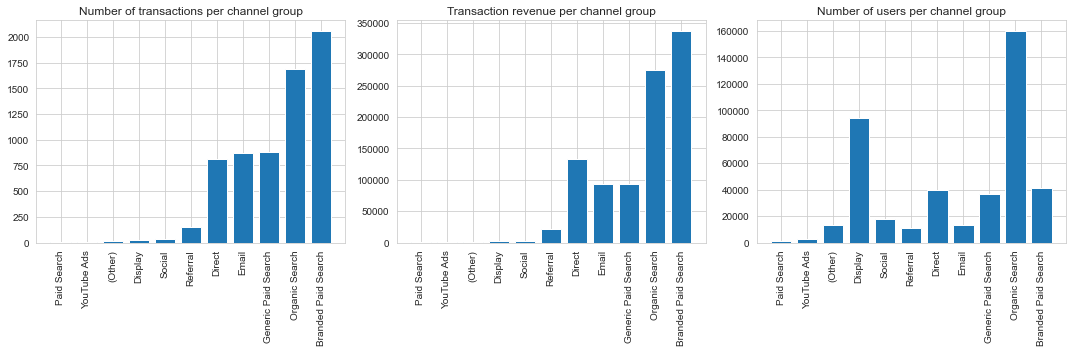

In [1100]:
# change figure size 
fig = plt.figure() 
fig.set_figheight(5)
fig.set_figwidth(15)
plt.grid(False) 

plt.subplot(1, 3, 1) # row 1, col 2 index 1
plt.bar(df_grouped_by_channel_general['Channel group'], df_grouped_by_channel_general['Transactions'])
plt.xticks(rotation = 90)
plt.title('Number of transactions per channel group')

plt.subplot(1, 3, 2) # index 2
plt.bar(df_grouped_by_channel_general['Channel group'], df_grouped_by_channel_general['Transaction revenue'])
plt.xticks(rotation = 90)
plt.title('Transaction revenue per channel group')

plt.subplot(1,3,3)
plt.bar(df_grouped['Channel group'], df_grouped['Users'])
plt.xticks(rotation = 90)
plt.title('Number of users per channel group')

# minimize overlap 
plt.tight_layout()
plt.show()

In [1101]:
df_grouped_by_channel_general

,Channel group,Users,Transactions,Transaction revenue,Transactions per user,Revenue per user,Revenue per transaction,Users percentage,Transaction revenue percentage,Transaction percentage
7,Paid Search,1149,1,210.00,0.000870,0.182768,210.000000,0.002662,0.000219,0.000153
10,YouTube Ads,3027,3,485.00,0.000991,0.160225,161.666667,0.007013,0.000505,0.000459
0,(Other),13474,13,1631.00,0.000965,0.121048,125.461538,0.031216,0.001697,0.001989
3,Display,93972,23,2656.50,0.000245,0.028269,115.500000,0.217714,0.002764,0.003520
9,Social,18136,36,2528.00,0.001985,0.139391,70.222222,0.042017,0.002630,0.005509
8,Referral,11181,147,22365.40,0.013147,2.000304,152.145578,0.025904,0.023272,0.022494
2,Direct,39340,815,132499.62,0.020717,3.368064,162.576221,0.091143,0.137870,0.124713
4,Email,13098,874,92681.96,0.066728,7.076039,106.043432,0.030345,0.096439,0.133741
5,Generic Paid Search,36838,877,93604.88,0.023807,2.540987,106.733044,0.085346,0.097399,0.134200
6,Organic Search,159853,1690,275283.65,0.010572,1.722105,162.889734,0.370346,0.286442,0.258607


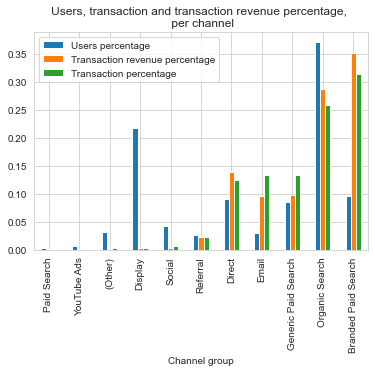

In [1102]:
# df_grouped_by_channel_general.plot(x='Channel group', y=['Transactions per user', 'Revenue per user'], grid=True)
# plotting graph
df_grouped_by_channel_general.plot(x='Channel group', y=['Users percentage', 'Transaction revenue percentage', 'Transaction percentage'], kind="bar")
plt.title('Users, transaction and transaction revenue percentage, \n per channel')
plt.legend() 
plt.show()

Boxplot of channel vs transaction revenue. First, we need to drop outliers in transaction revenue 

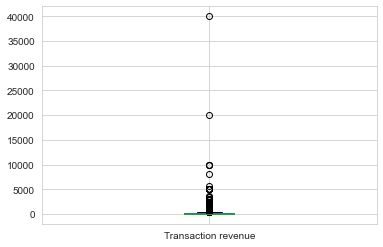

In [1244]:
df_eda[df_eda['Transaction revenue'] > 0].boxplot('Transaction revenue')
df_eda_without_transactionrevenue_outliers = df_eda[df_eda['Transaction revenue'] > 0]

In [1245]:
# extract q75 and q25 for transactions > 0 (otherwise both values are 0) 
q75, q25 = np.percentile(df_eda_without_transactionrevenue_outliers['Transaction revenue'], [75,25])
q75, q25
intr_qr = q75-q25

# extract outliers 
max = q75+(1.5*intr_qr)
max

# drop outliers from df_eda_without_transactionrevenue_outliers 
# df_eda_without_transactionrevenue_outliers[df_eda_without_transactionrevenue_outliers['Transaction revenue'] > max] # 343 rows 
df_eda_without_transactionrevenue_outliers[df_eda_without_transactionrevenue_outliers['Transaction revenue'] > max] = np.nan 
df_eda_without_transactionrevenue_outliers = df_eda_without_transactionrevenue_outliers.dropna(axis = 0)

Text(0.5, 1.0, 'Distribution of transaction revenue')

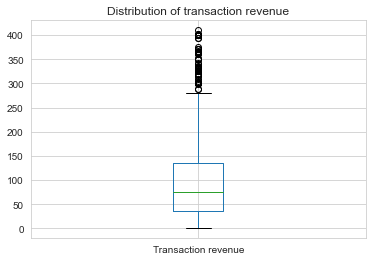

In [1246]:
df_eda_without_transactionrevenue_outliers.boxplot('Transaction revenue')
plt.title('Distribution of transaction revenue')

In [1386]:
df_eda_without_transactionrevenue_outliers['Channel group'].value_counts()

Branded Paid Search    1796
Organic Search         1447
Generic Paid Search     803
Email                   788
Direct                  686
Referral                 91
Social                   35
Display                  22
(Other)                  12
YouTube Ads               3
Paid Search               1
Name: Channel group, dtype: int64

Channel group
Branded Paid Search    410.0
Organic Search         400.0
Generic Paid Search    402.0
Email                  365.0
Direct                 400.0
Referral               365.0
Social                 264.0
Display                210.0
(Other)                240.0
YouTube Ads            240.0
Paid Search            210.0
Name: Transaction revenue, dtype: float64


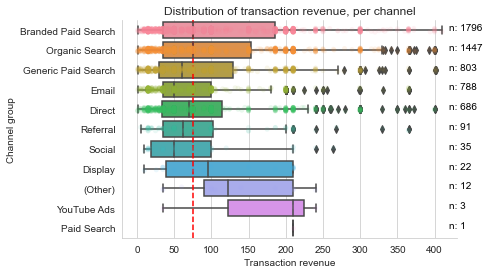

In [1392]:
# https://www.python-graph-gallery.com/38-show-number-of-observation-on-boxplot 
# df_eda_without_transactionrevenue_outliers[df_eda_without_transactionrevenue_outliers['Transaction revenue'] > 0].groupby(['Channel group'])['Transaction revenue'].apply(lambda x: np.percentile(x,75))
max_vector = df_eda_without_transactionrevenue_outliers.groupby(['Channel group'])['Transaction revenue'].max()
order_to_plot = ['Branded Paid Search', 'Organic Search', 'Generic Paid Search', 'Email', 'Direct', 'Referral', 'Social',  'Display', '(Other)', 'YouTube Ads', 'Paid Search']
# reorder vector 
max_vector = max_vector[order_to_plot]
print(max_vector)
nobs = df_eda_without_transactionrevenue_outliers['Channel group'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

# boxplot of transaction revenue vs channel group 
ax= sns.boxplot(y='Channel group',x='Transaction revenue',data=df_eda_without_transactionrevenue_outliers, order = order_to_plot)
ax = sns.stripplot(y="Channel group", x="Transaction revenue",data=df_eda_without_transactionrevenue_outliers, alpha = 0.1, order = order_to_plot)

plt.axvline(x=75, # median transactions 
            color='red', ls = '--')
# add nobs to plot 
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(420,
            tick, 
            nobs[tick],
            horizontalalignment='left',
            color = 'black')
            #color='b',
            # weight='semibold')
sns.despine() 
plt.title('Distribution of transaction revenue, per channel')
plt.show()

##### Number of clientIDs per channel/source/medium

Results for channel group =  Organic Search


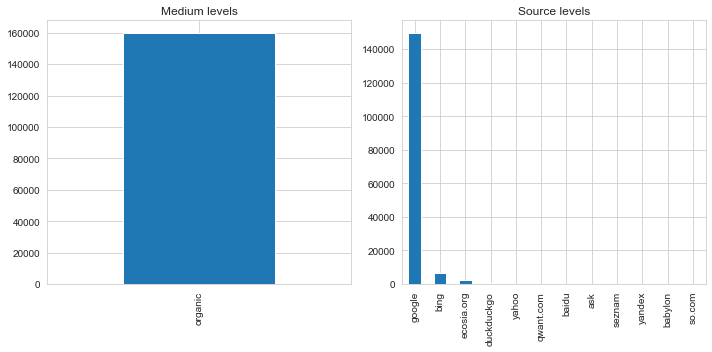

Results for channel group =  Display


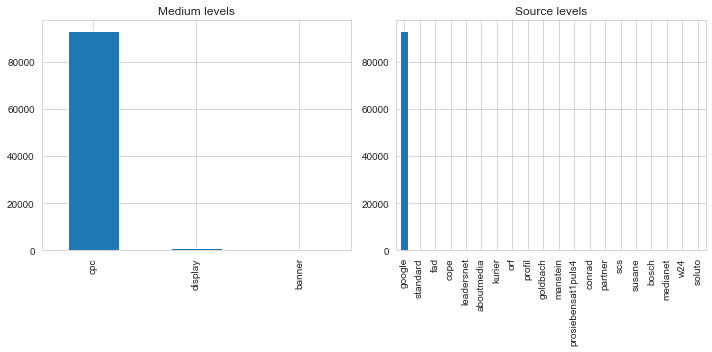

Results for channel group =  Branded Paid Search


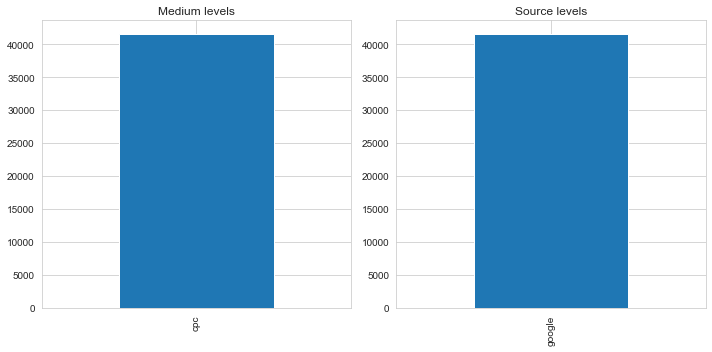

Results for channel group =  Direct


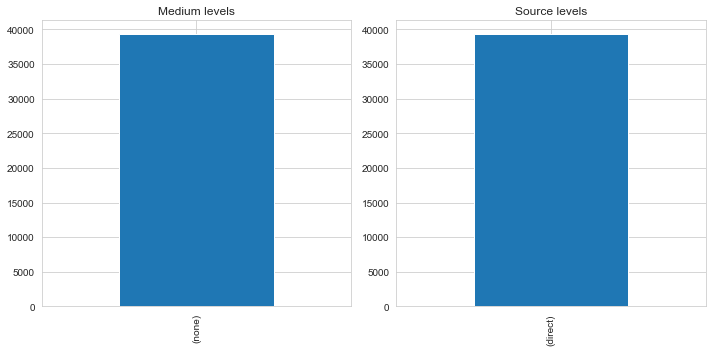

Results for channel group =  Generic Paid Search


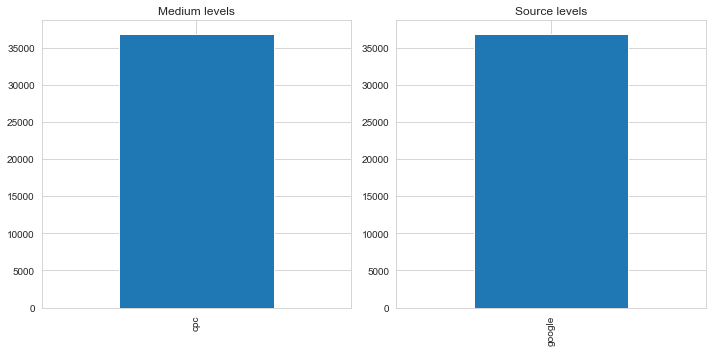

Results for channel group =  Referral


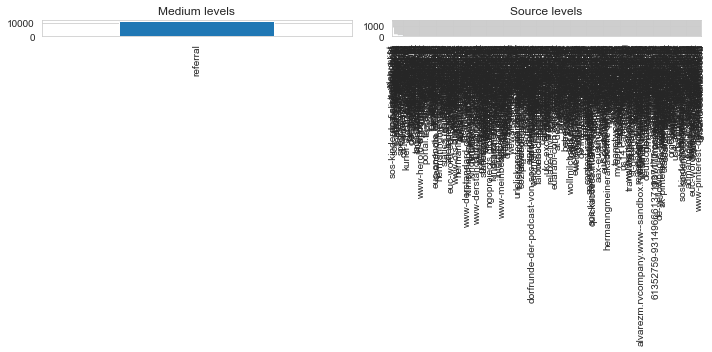

Results for channel group =  Social


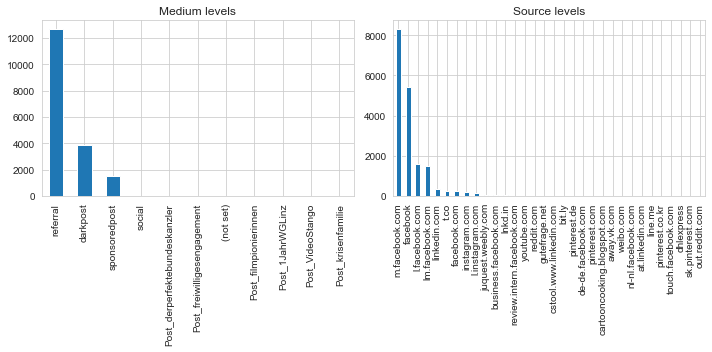

Results for channel group =  Email


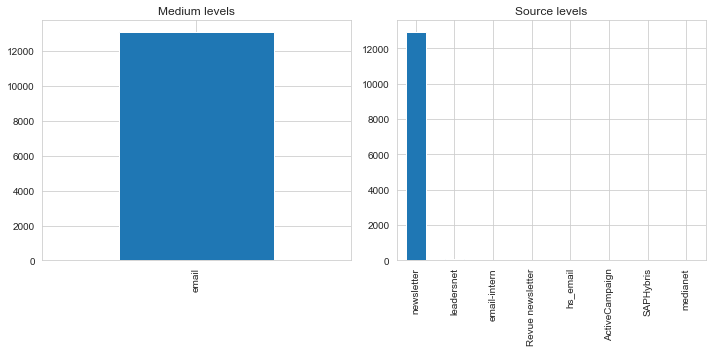

Results for channel group =  (Other)


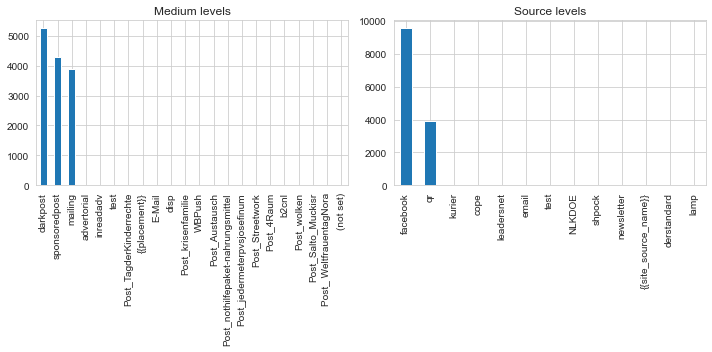

Results for channel group =  YouTube Ads


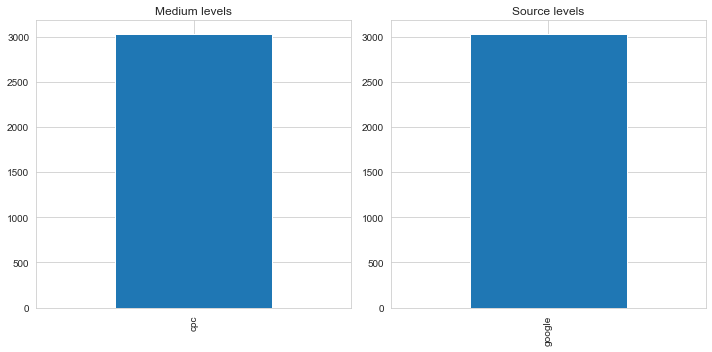

Results for channel group =  Paid Search


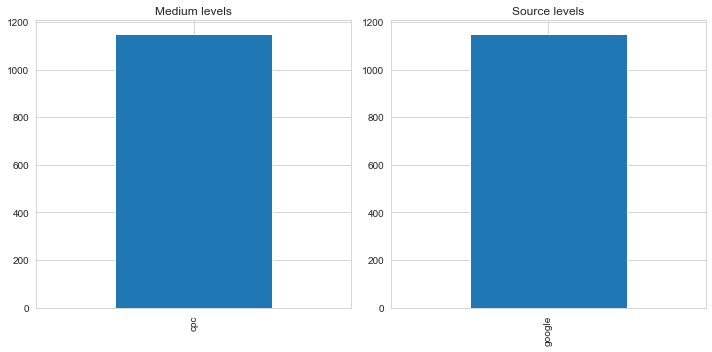

Text(0.5, 1.0, 'Medium levels')

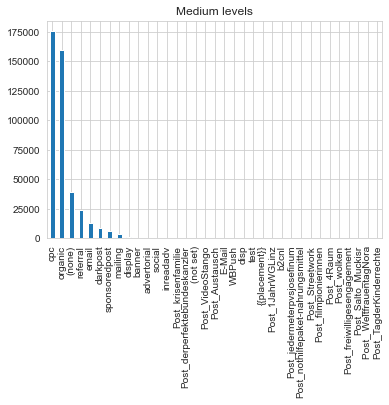

In [1186]:
# df_eda['User type'].value_counts()
channel_groups = ['Organic Search', 'Display', 'Branded Paid Search', 'Direct', 'Generic Paid Search', 'Referral', 'Social', 'Email', '(Other)', 'YouTube Ads', 'Paid Search']
for channel in channel_groups: 
    print('Results for channel group = ', channel)
    channel_df = df_eda[df_eda['Channel group'] == channel]
    # plot medium and source in 2 subplots
    fig = plt.figure() 
    fig.set_figheight(5)
    fig.set_figwidth(10)
    plt.subplot(1, 2, 1) # row 1, col 2 index 1
    channel_df['Medium'].value_counts().plot(kind = 'bar')
    plt.xticks(rotation = 90)
    plt.title('Medium levels')
    plt.subplot(1, 2, 2) # index 2
    channel_df['Source'].value_counts().plot(kind = 'bar')
    plt.xticks(rotation = 90)
    plt.title('Source levels')
    # minimize overlap 
    plt.tight_layout()
    plt.show()
# df_eda['Source'].value_counts().plot(kind = 'bar')
# plt.title('Source levels')
df_eda['Medium'].value_counts().plot(kind = 'bar')
plt.title('Medium levels')

#### Focus: conversions vs weekday and hour 

In [1315]:
# add weekday 
df_eda['weekday'] = df_eda['Date'].dt.day_name()
# print('Weekday summary')
# print(df_eda['weekday'].value_counts())

# add hour 
df_eda['hour'] = df_eda['timestamp_start'].dt.hour
# print('hour summary') 
# print(df_eda['hour'].value_counts())

In [1163]:
rownames1 = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
c = pd.crosstab(index = df_eda['weekday'], columns = df_eda['hour'])
c = pd.DataFrame(c, index = rownames1)
c

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Monday,1021,462,319,205,209,467,1012,1977,3644,4488,...,4442,4617,4121,3849,3825,3791,3472,3463,2390,1365
Tuesday,968,474,268,205,235,444,1075,2171,3614,4389,...,4159,4097,3997,3604,3430,3459,3560,3469,3255,1512
Wednesday,1000,456,251,213,259,470,1150,2306,3791,4645,...,4563,4292,4019,3673,3576,3701,3498,3166,2336,1390
Thursday,920,450,261,233,223,472,1151,2321,3682,4653,...,4863,4278,3976,3669,3249,3432,3252,2874,2292,1254
Friday,984,501,323,235,244,484,1150,2270,3686,4495,...,3719,3654,3411,3377,2932,3140,3192,2922,2291,1397
Saturday,1096,574,367,233,202,331,737,1636,2580,2916,...,2705,2777,2817,2719,2852,3186,2777,2362,1963,1283
Sunday,1032,578,362,243,222,279,592,1368,2466,3100,...,2664,2542,2837,3099,3256,4671,4340,3020,2555,1379


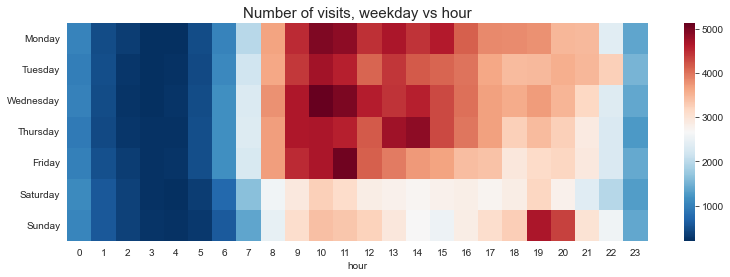

In [1164]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(13, 4))
sns.heatmap(c, cmap="RdBu_r")
plt.title('Number of visits, weekday vs hour', fontdict={'fontsize': 15})
plt.show()

In [1165]:
rownames1 = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
test1 = df_eda[['weekday', 'hour', 'Transactions']]
test1 = test1.groupby(['weekday', 'hour']).sum() 
test1 = test1.reset_index()

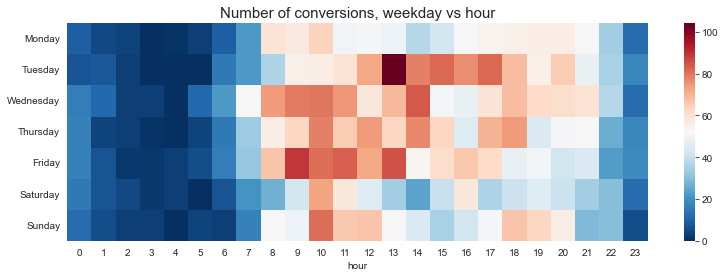

In [1166]:
c = pd.pivot_table(data=test1, 
                        index=['weekday'], 
                        columns=['hour'], 
                        values='Transactions') 
c = pd.DataFrame(c, index = rownames1)
# c

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(13, 4))
sns.heatmap(c, cmap="RdBu_r")
plt.title('Number of conversions, weekday vs hour', fontdict={'fontsize': 15})
plt.show()

In [1317]:
# check dates of email campaigns 
df_eda[df_eda['Channel group'] == 'Email']['Date'].value_counts()

2021-10-27    1342
2021-04-02    1267
2021-08-17     488
2021-05-20     467
2021-04-29     454
2021-02-10     432
2021-10-28     371
2021-08-10     336
2021-06-10     302
2021-04-03     302
2021-03-04     261
2021-04-01     241
2021-11-11     228
2021-11-23     227
2021-08-11     222
2021-12-01     219
2021-10-05     192
2021-08-18     182
2021-09-05     182
2021-12-31     181
2021-10-29     151
2021-04-06     140
2021-04-04     134
2021-12-03     129
2021-02-11     115
2021-04-05     115
2021-04-30     110
2021-11-19     109
2021-11-02     109
2021-12-02     101
2021-10-30      95
2021-10-07      92
2021-10-31      91
2021-11-01      79
2021-05-21      79
2021-11-24      72
2021-03-05      71
2021-11-12      66
2021-10-06      65
2021-04-07      63
2021-08-19      62
2021-06-11      58
2021-09-06      54
2021-03-03      52
2021-12-04      51
2021-05-04      51
2021-08-12      51
2021-11-03      45
2021-03-09      42
2021-08-25      40
2021-12-06      40
2021-10-08      39
2021-04-08  

In [1318]:
# try to figure out whats that peak on Tuesday at 13 hours
test1 = df_eda[df_eda['weekday'] == 'Tuesday'] 
test2 = test1[test1['hour'] == 13]
test3 = test2[test2['Transactions'] > 0]
print(len(test3))
test3[['Date', 'Channel group']].value_counts()

103


Date        Channel group      
2021-08-17  Email                  49
2021-08-10  Email                   8
2021-11-23  Email                   6
2021-12-14  Branded Paid Search     4
2021-10-05  Email                   3
2021-08-10  Direct                  2
2021-03-02  Organic Search          2
2021-09-28  Branded Paid Search     1
2021-08-24  Generic Paid Search     1
            Organic Search          1
2021-08-31  Branded Paid Search     1
2021-09-14  Branded Paid Search     1
2021-01-05  Direct                  1
2021-08-24  Email                   1
2021-11-02  Direct                  1
2021-11-16  Organic Search          1
2021-12-14  Generic Paid Search     1
2021-12-21  Branded Paid Search     1
            Organic Search          1
2021-11-02  Branded Paid Search     1
2021-08-17  Direct                  1
2021-01-05  Generic Paid Search     1
2021-08-10  Organic Search          1
2021-05-04  Direct                  1
            Branded Paid Search     1
2021-04-13  Organi

In [1319]:
test3 = test2[test2['Transactions'] > 0][['Date', 'Channel group']]
test3[test3['Channel group'] == 'Email']

,Date,Channel group
6610,2021-08-17,Email
14188,2021-08-17,Email
19002,2021-08-24,Email
22951,2021-08-17,Email
23881,2021-08-17,Email
33479,2021-08-17,Email
42420,2021-08-17,Email
51608,2021-08-17,Email
52679,2021-08-17,Email
54684,2021-08-17,Email


In [1320]:
# try to figure out whats that peak on Friday at 9 hours
test1 = df_eda[df_eda['weekday'] == 'Friday'] 
test2 = test1[test1['hour'] == 9]
test3 = test2[test2['Transactions'] > 0]
test3[['Date', 'Channel group']].value_counts()

Date        Channel group      
2021-12-24  Branded Paid Search    10
            Organic Search          4
            Generic Paid Search     4
2021-12-31  Branded Paid Search     3
2021-12-24  Direct                  3
2021-12-31  Organic Search          2
2021-12-10  Branded Paid Search     2
2021-04-23  Branded Paid Search     2
2021-04-09  Email                   2
2021-08-20  Email                   2
2021-01-22  Generic Paid Search     2
2021-12-17  Branded Paid Search     1
2021-10-08  Email                   1
2021-08-27  Branded Paid Search     1
            Organic Search          1
2021-09-03  Direct                  1
            Organic Search          1
2021-09-17  Branded Paid Search     1
2021-09-24  Organic Search          1
2021-10-01  Referral                1
2021-10-22  Organic Search          1
2021-12-10  Email                   1
2021-11-12  Branded Paid Search     1
            Organic Search          1
2021-11-26  Branded Paid Search     1
2021-08-20  Brande

In [1321]:
test3 = test3[['Date', 'Channel group']]
len(test3[test3['Channel group'] == 'Email'])

10

#### Focus: other features 

Explore other features to have an idea on profile of touchpoints with/without transaction. At first, without taking into account channel groups

* `Operating system`
* `Total time on site`
* `Pageviews`
* `time_start`, `timestamp_diff`

In [1248]:
print('Number of users: ', df_eda['Users'].value_counts()) 
print('Number of transactions: ', df_eda.Transactions.sum())

Number of users:  1    431631
Name: Users, dtype: int64
Number of transactions:  6535


In [1228]:
# avg visit duration
print(df_eda['Total time on site'].mean())
# visits with duration == 0 
print(len(df_eda[df_eda['Total time on site'] == 0])) # 252548 

96.54747921256815
252548
205


In [1229]:
# number of transactions from visits with time == 0
print(df_eda[df_eda['Total time on site'] == 0]['Transactions'].sum()) # 205 
# channel of those transactions 
df_eda[(df_eda['Total time on site'] == 0) & (df_eda['Transactions'] > 0)]['Channel group'].value_counts()

Direct                 66
Email                  41
Branded Paid Search    41
Organic Search         21
Generic Paid Search    15
Display                 2
Referral                2
Name: Channel group, dtype: int64

In [1249]:
df_other_feats = df_eda[['clientID', 'Date', 'Users', 'Operating system', 'Transactions', 'Transaction revenue', 'Total time on site', 'Pageviews', 'time_start', 'timestamp_diff', 'general_type_of_client']]
# df_other_feats

**Focus: time_start**

Text(0, 0.5, 'Number of transactions')

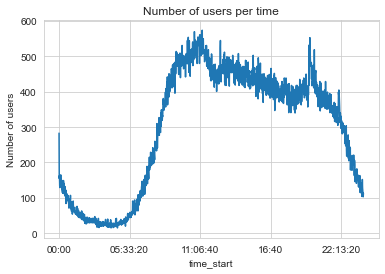

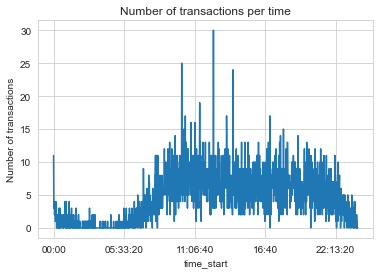

In [1195]:
df_eda[['time_start', 'Users']].groupby(['time_start']).sum('Users').plot(legend = None)
plt.title('Number of users per time')
plt.ylabel('Number of users')

df_eda[['time_start', 'Transactions']].groupby(['time_start']).sum().plot(legend = None)
plt.title('Number of transactions per time')
plt.ylabel('Number of transactions')


**Focus: operating system**

In [1196]:
df_eda['Operating system'].value_counts()

Android          185229
iOS              109772
Windows          106433
Macintosh         27920
Linux              1640
Chrome OS           556
Tizen                26
(not set)            20
BlackBerry           13
Windows Phone        13
Playstation 4         4
Firefox OS            2
OS/2                  1
Nokia                 1
Xbox                  1
Name: Operating system, dtype: int64

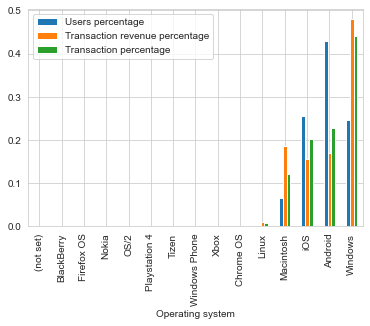

In [1197]:
feats_to_select = ['Operating system', 'Users', 'Transactions', 'Transaction revenue']
feat_to_group_by = 'Operating system'
feat_to_order_table_by = 'Transactions'
df_grouped_by_os = grouped_df(df_eda, feats_to_select, feat_to_group_by, feat_to_order_table_by)
# df_grouped_by_os

df_grouped_by_os.plot(x='Operating system', y=['Users percentage', 'Transaction revenue percentage', 'Transaction percentage'], kind="bar")
plt.title('')
plt.legend() 
plt.show()

In [1250]:
max_vector = df_eda_without_transactionrevenue_outliers.groupby(['Operating system'])['Transaction revenue'].max()
max_vector

Operating system
Android      400.0
Chrome OS    300.0
Linux        365.0
Macintosh    402.0
Windows      410.0
iOS          400.0
Name: Transaction revenue, dtype: float64

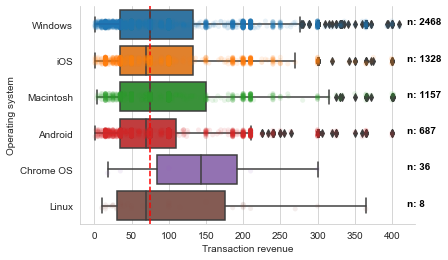

In [1251]:
max_vector = df_eda_without_transactionrevenue_outliers.groupby(['Operating system'])['Transaction revenue'].max()
# reorder vector 
order_to_plot = ['Windows', 'iOS', 'Macintosh', 'Android', 'Chrome OS', 'Linux'] # extracted after plotting it once 
max_vector = max_vector[order_to_plot]
nobs = df_eda_without_transactionrevenue_outliers['Operating system'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

# boxplot of transaction revenue vs channel group 
ax= sns.boxplot(y='Operating system',x='Transaction revenue',data=df_eda_without_transactionrevenue_outliers)
ax = sns.stripplot(y="Operating system", x="Transaction revenue",data=df_eda_without_transactionrevenue_outliers, alpha = 0.1)

plt.axvline(x=75, # median transactions 
            color='red', ls = '--')
# add nobs to plot 
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(420,
            tick, 
            nobs[tick],
            horizontalalignment='left',
            color = 'black',  
            #color='b',
            weight='semibold')
sns.despine() 
plt.show()

**Focus: Total time on site**

In [1260]:
# create feature of transaction yes/no 
df_eda['transaction_yes_no'] = np.where(df_eda['Transactions'] > 0, 'yes', 'no')

# pageviews 
q75_pageviews, q25_pageviews = np.percentile(df_eda['Total time on site'], [75,25])
intr_qr_pageviews = q75_pageviews - q25_pageviews
max_pageviews = q75_pageviews+(1.5*intr_qr_pageviews)

# total time on site 
q75_total_time, q25_total_time = np.percentile(df_eda['Pageviews'], [75,25])
intr_qr_total_time = q75_total_time - q25_total_time
max_total_time = q75_total_time+(1.5*intr_qr_total_time)


In [ ]:
# df_eda.Transactions.sum()

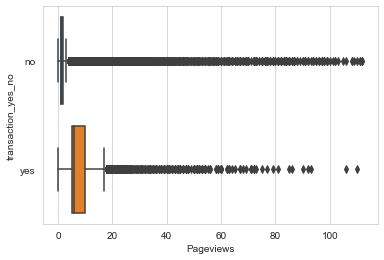

In [1263]:
# drop outliers to plot pageviews 
df_eda_copy = df_eda[:] 
df_eda_copy[df_eda_copy['Pageviews'] > max_pageviews] = np.nan 
df_eda_copy = df_eda_copy.dropna(axis = 0)

ax= sns.boxplot(y='transaction_yes_no',x='Pageviews',data=df_eda_copy)

In [1264]:
df_eda.Transactions.sum()

6535

In [1202]:
def get_data_summary (df, feat_of_interest, feat2): 
    print('Results for all data') 
    print('Min.', feat_of_interest, 'for all data: ', df[feat_of_interest].min())
    print('Max.', feat_of_interest, 'for all data: ', df[feat_of_interest].max())
    print('Avg.', feat_of_interest, 'for all data: ', round(df[feat_of_interest].sum() / len(df)))
    print('Median', feat_of_interest, 'for all data: ', statistics.median(df[feat_of_interest]))
    print('Results for users WITH transaction')
    print('Min.', feat_of_interest, 'for users WITH transaction: ', df[feat_of_interest][df[feat2] > 0].min())
    print('Max.', feat_of_interest, 'for users WITH transaction: ', df[feat_of_interest][df[feat2] > 0].max())
    print('Avg.', feat_of_interest, 'for users WITH transaction: ', round(df[feat_of_interest].sum() / len(df[feat_of_interest][df[feat2] > 0])))
    print('Median', feat_of_interest, 'for users WITH transaction: ', statistics.median(df[feat_of_interest][df[feat2] > 0]))
    print('Results for users without transaction')
    print('Min.', feat_of_interest, 'for users without transaction: ', df[feat_of_interest][df[feat2] == 0].min())
    print('Max.', feat_of_interest, 'for users without transaction: ', df[feat_of_interest][df[feat2] == 0].max())
    print('Avg.', feat_of_interest, 'for users without transaction: ', round(df[feat_of_interest].sum() / len(df[feat_of_interest][df[feat2] == 0])))
    print('Median', feat_of_interest, 'for users without transaction: ', statistics.median(df[feat_of_interest][df[feat2] == 0]))

In [1203]:
get_data_summary(df_eda, 'Pageviews', 'Transactions')

Results for all data
Min. Pageviews for all data:  0.0
Max. Pageviews for all data:  112.0
Avg. Pageviews for all data:  2
Median Pageviews for all data:  11.0
Results for users WITH transaction
Min. Pageviews for users WITH transaction:  0.0
Max. Pageviews for users WITH transaction:  110.0
Avg. Pageviews for users WITH transaction:  170
Median Pageviews for users WITH transaction:  6.0
Results for users without transaction
Min. Pageviews for users without transaction:  0.0
Max. Pageviews for users without transaction:  112.0
Avg. Pageviews for users without transaction:  2
Median Pageviews for users without transaction:  1.0


In [1204]:
get_data_summary(df_eda, 'Total time on site', 'Transactions')

Results for all data
Min. Total time on site for all data:  0.0
Max. Total time on site for all data:  30769.0
Avg. Total time on site for all data:  96
Median Total time on site for all data:  0.0
Results for users WITH transaction
Min. Total time on site for users WITH transaction:  0.0
Max. Total time on site for users WITH transaction:  9338.0
Avg. Total time on site for users WITH transaction:  6878
Median Total time on site for users WITH transaction:  327.0
Results for users without transaction
Min. Total time on site for users without transaction:  0.0
Max. Total time on site for users without transaction:  30769.0
Avg. Total time on site for users without transaction:  97
Median Total time on site for users without transaction:  0.0


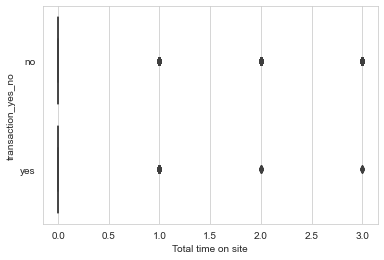

In [1265]:
# drop outliers to plot total time on site  
df_eda_copy = df_eda[:] 
df_eda_copy[df_eda_copy['Total time on site'] > max_total_time] = np.nan 
df_eda_copy = df_eda_copy.dropna(axis = 0)

ax= sns.boxplot(y='transaction_yes_no',x='Total time on site',data=df_eda_copy)

#### Focus: Internal data 

(!) Attention! Features `Total time on site` and `Pageviews` are not correct, maybe because I just gather the exact data (hour/minute) of the transaction, and that data is on the first row (also, the first minute when the visit started). 
We should then merge the data with `df_eda` and will consider that data as the single point of truth. Also the transaction revenue is not the same if querying the transaction ID or not. 

In [1322]:
df_transactions_supermetrics.head()

,clientID,Date,Hour,Minute,Transaction ID,Channel group,Source,Device category,Operating system,Users,Transactions,Transaction revenue,Total time on site,Pageviews
0,39565.1609585172,2021-01-02,12,09,0167-6629043201,Referral,startpage.com,desktop,Windows,1,1,35,0,0
1,1197085.1609745532,2021-01-04,08,41,0131-6630646616,Generic Paid Search,google,desktop,Windows,1,1,15,0,0
2,2027477.1617603152,2021-04-05,08,33,0162-6709265155,Branded Paid Search,google,desktop,Chrome OS,1,1,210,0,0
3,4329912.1609958594,2021-01-06,19,50,0177-6632775842,Organic Search,google,desktop,Windows,1,1,500,0,0
4,4820105.1611613176,2021-02-01,01,00,0283-6654562842,Generic Paid Search,google,desktop,Windows,1,1,300,0,0


In [1323]:
# drop features that do not agree with df_eda 
# df_transactions_supermetrics.drop('Transaction revenue', axis = 1, inplace = True)
df_transactions_supermetrics.drop('Total time on site', axis = 1, inplace = True)
df_transactions_supermetrics.drop('Pageviews', axis = 1, inplace = True)

In [1324]:
# df_transactions_frnow = pd.read_csv(r'C:\Users\carol\OneDrive\Escritorio\FH Kufstein\MT\analysis\transaction_table_v3.csv', sep = ";", encoding = "ISO-8859-1")
df_transactions_frnow = pd.read_excel(r'C:\Users\carol\OneDrive\Escritorio\FH Kufstein\MT\analysis\transaction_table_v3.xlsx')
df_transactions_frnow.head()

,transaction_id,contact_number,reference_type,campaign_activity,lts,startdate_contact,gender,age
0,0101-6715423348,36606101,Contribution,271920 - Elternseite Spenden für Beratung ab 20 (20008),430.00,2006-12-21,männlich,68.0
1,0101-6914356363,51971430,Contribution,2810 - Spendenshop KDOE,40.00,2021-11-28,weiblich,72.0
2,0102-6673917396,51840346,Commitment,2870 - Paten Internet allgem. HK,738.00,2021-02-23,männlich,81.0
3,0102-6915819493,19382746,Contribution,1681457 - newsl_dig2021_12 freunde,979.94,1981-01-01,männlich,46.0
4,0103-6660495146,51665933,Commitment,2870 - Paten Internet allgem. HK,927.40,2011-08-03,männlich,85.0


In [1325]:
# change levels of gender - into English 
df_transactions_frnow['gender'] = df_transactions_frnow['gender'].replace({'männlich':'m', 'weiblich':'w', 'unbekannt':'unknown'})

# check those of reference_type = "activity"
df_transactions_frnow['reference_type'].value_counts()
df_transactions_frnow.loc[df_transactions_frnow['reference_type'] == 'Activity']['campaign_activity'].value_counts()

2808 - Kartenshop KDOE    115
Name: campaign_activity, dtype: int64

In [1326]:
# pretreatment - transform class 
df_transactions_frnow['lts'] = pd.to_numeric(df_transactions_frnow['lts'], errors = 'coerce')
df_transactions_frnow['startdate_contact'] = pd.to_datetime(df_transactions_frnow['startdate_contact'], format = '%d.%m.%Y')

# change name of feature 
df_transactions_frnow.rename(columns = {'transaction_id':'Transaction ID'}, inplace = True)

In [1327]:
print('Number of transactions in supermetrics: ', df_transactions_supermetrics['Transactions'].sum()) 
print('Number of transactions in original dataset: ', df['Transactions'].sum())

Number of transactions in supermetrics:  8072
Number of transactions in original dataset:  8072


Some inconsistencies still seem to exist. See for instance clientID 1354244725.1607358890, with 0 Transactions in `df_transactions_supermetrics` and one transaction in `df_eda`. We will therefore take information on original dataset as the single point of truth, also in terms of transactions (because the information seems to exist in df_transactions_supermetrics, there are just some inconsistencies in features like transactions, transaction revenue)

In [1328]:
# filter rows where Transactions == 0 
df_transactions_supermetrics = df_transactions_supermetrics[df_transactions_supermetrics['Transactions'] > 0]
# df_transactions_supermetrics[df_transactions_supermetrics['Transactions'] == 0]
# df_transactions_supermetrics

In [1330]:
# merge transaction tables 
df_merged_transactions = pd.merge(left = df_transactions_supermetrics, right = df_transactions_frnow, how = 'left', on = 'Transaction ID')
# filter those without contact number - because no internal information exist for those 
df_merged_transactions = df_merged_transactions[df_merged_transactions['contact_number'].notnull()]

In [1332]:
# initial numbers 
print('N. obs. of df_merged_transactions: ', len(df_merged_transactions))
print('N. transactions. in df_eda: ', df_eda['Transactions'].sum())
print('N. of unique contact number: ', df_merged_transactions['clientID'].nunique())

N. obs. of df_merged_transactions:  7700
N. transactions. in df_eda:  6535
N. of unique contact number:  6666


In [1333]:
# filter rows of Karriere visits and #GivingTuesday 
df_merged_transactions = df_merged_transactions[-df_merged_transactions['clientID'].isin(karriere1)]
df_merged_transactions = df_merged_transactions[-df_merged_transactions['clientID'].isin(karriere2)]
df_merged_transactions = df_merged_transactions[-df_merged_transactions['clientID'].isin(df_transactions_supermetrics)]
df_merged_transactions = df_merged_transactions[df_merged_transactions['Date'] != '2021-11-30']

# numbers after filtering 
print('N. obs. of df_merged_transactions: ', len(df_merged_transactions))
print('N. transactions. in df_eda: ', df_eda['Transactions'].sum())
print('N. of unique contact number: ', df_merged_transactions['clientID'].nunique())

N. obs. of df_merged_transactions:  6191
N. transactions. in df_eda:  6535
N. of unique contact number:  5333


In [1334]:
# transform into number 
df_merged_transactions['Transactions'] = pd.to_numeric(df_merged_transactions['Transactions'], errors = 'coerce')
df_merged_transactions['Transaction revenue'] = pd.to_numeric(df_merged_transactions['Transaction revenue'], errors = 'coerce')
df_merged_transactions['Users'] = pd.to_numeric(df_merged_transactions['Users'], errors = 'coerce')

In [1335]:
# transform Date into datetime 
df_merged_transactions['Date'] = pd.to_datetime(df_merged_transactions['Date'])
print('max timestamp: ', df_merged_transactions['Date'].min()) # ok
print('min timestamp: ', df_merged_transactions['Date'].max()) # ok

max timestamp:  2021-01-01 00:00:00
min timestamp:  2021-12-31 00:00:00


In [1336]:
# add weekday 
df_merged_transactions['weekday'] = df_merged_transactions['Date'].dt.day_name()

In [1339]:
df_eda.Transactions.sum()

# merge with df_eda to get info about total time on site and pageviews 
df_eda_sub = df_eda[['clientID', 'Date', 'Channel group', 'Total time on site', 'Pageviews', 'hour']]
df_eda_sub

,clientID,Date,Channel group,Total time on site,Pageviews,hour
0,1000005671.1568444004,2021-01-04,Display,0,1,22
1,1000006728.1622927843,2021-06-05,Direct,0,1,23
2,1000020259.1556972396,2021-01-31,Referral,0,1,19
4,1000024791.1630470945,2021-09-01,Branded Paid Search,38,2,6
5,1000025674.1610314739,2021-01-10,Organic Search,0,1,22
...,...,...,...,...,...,...
467915,999973068.1611254848,2021-01-21,Display,0,1,19
467916,99997309.1608586309,2021-01-04,Display,0,1,16
467917,999988377.1636720143,2021-11-12,Display,0,1,13
467918,999996741.1623865085,2021-06-16,(Other),0,1,19


In [1341]:
df_merged_transactions = pd.merge(left = df_merged_transactions, right = df_eda_sub, how = 'left', on = ['clientID', 'Date', 'Channel group'])

In [1285]:
print('Number of transactions: ', df_merged_transactions['Transactions'].sum())
print('Number of unique clientIDs: ', df_merged_transactions.clientID.nunique())
print('Number of unique clientIDs: ', df_merged_transactions.contact_number.nunique())

Number of transactions:  6191
Number of unique clientIDs:  5333
Number of unique clientIDs:  5048


In [1346]:
# impute the "in theory real" value of entry errors, checked internally 
df_merged_transactions.loc[df_merged_transactions.clientID == '676908493.1607510701', 'Transaction revenue'] = 600
df_merged_transactions.loc[df_merged_transactions.clientID == '97296655.1614192922', 'Transaction revenue'] = 210

Check characteristics of donations, focus on `reference_type`

In [1348]:
df_merged_transactions['Transaction revenue'].max()

40000.0

In [1350]:
df_merged_transactions['Transactions'].sum()

6193

In [1349]:
df_merged_transactions['reference_type'].value_counts()

Contribution    5282
Commitment       824
Activity          87
Name: reference_type, dtype: int64

In [1351]:
df_merged_transactions_grouped_by_type = df_merged_transactions[['reference_type', 'Users', 'Transactions', 'Transaction revenue', 'Total time on site', 'Pageviews']]
df_merged_transactions_grouped_by_type = df_merged_transactions_grouped_by_type.groupby(['reference_type']).sum()
df_merged_transactions_grouped_by_type['Total time/conv'] = df_merged_transactions_grouped_by_type['Total time on site'] / df_merged_transactions_grouped_by_type['Transactions']
df_merged_transactions_grouped_by_type['Pageviews/conv'] = df_merged_transactions_grouped_by_type['Pageviews'] / df_merged_transactions_grouped_by_type['Transactions']
df_merged_transactions_grouped_by_type['Revenue/conv'] = df_merged_transactions_grouped_by_type['Transaction revenue'] / df_merged_transactions_grouped_by_type['Transactions']
df_merged_transactions_grouped_by_type

,Users,Transactions,Transaction revenue,Total time on site,Pageviews,Total time/conv,Pageviews/conv,Revenue/conv
reference_type,,,,,,,,
Activity,87,87,5940.8,91401,2516,1050.586207,28.919540,68.285057
Commitment,824,824,172935.0,614134,9548,745.308252,11.587379,209.872573
Contribution,5282,5282,706795.1,2813157,58226,532.593147,11.023476,133.812022


In [ ]:
print(df_merged_transactions_grouped_by_type.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  Users &  Transactions &  Transaction revenue &  Total time on site &  Pageviews \\
reference\_type &        &               &                      &                     &            \\
\midrule
Activity       &     87 &            87 &               5940.8 &               91401 &       2516 \\
Commitment     &    824 &           824 &             172935.0 &              614134 &       9548 \\
Contribution   &   5282 &          5282 &             706795.1 &             2813157 &      58226 \\
\bottomrule
\end{tabular}



In [ ]:
df_merged_transactions_grouped_by_type2 = df_merged_transactions[['reference_type', 'Channel group', 'Users', 'Transactions', 'Transaction revenue', 'Total time on site', 'Pageviews']]
df_merged_transactions_grouped_by_type2 = df_merged_transactions_grouped_by_type2.groupby(['Channel group', 'reference_type']).sum().reset_index()
test1 = df_merged_transactions_grouped_by_type2[['Channel group', 'reference_type', 'Transactions']]
test1
# test1 = df_merged_transactions_grouped_by_type2.groupby('Channel group')
# test1
# df_merged_transactions_grouped_by_type2 = df_merged_transactions_grouped_by_type2.groupby([['Channel group']]).sum()

,Channel group,reference_type,Transactions
0,(Other),Commitment,5
1,(Other),Contribution,8
2,Branded Paid Search,Activity,20
3,Branded Paid Search,Commitment,302
4,Branded Paid Search,Contribution,1680
5,Direct,Activity,11
6,Direct,Commitment,91
7,Direct,Contribution,608
8,Display,Commitment,9
9,Display,Contribution,13


In [ ]:
# Table of transactions per channel group and reference type 
c = pd.pivot_table(data=test1, 
                        index=['Channel group'], 
                        columns=['reference_type'], 
                        values='Transactions') 
total_activity = 87 
total_commitments = 824
total_contributions = 5282 
c['conv activity'] = round(c['Activity'] / total_activity * 100, 2)
c['conv commitment'] = round(c['Commitment'] / total_commitments * 100,2)
c['conv contribution'] = round(c['Contribution'] / total_contributions *100,2)

c

# c = pd.DataFrame(c, index = rownames1)

reference_type,Activity,Commitment,Contribution,conv activity,conv commitment,conv contribution
Channel group,,,,,,
(Other),NaN,5.0,8.0,NaN,0.61,0.15
Branded Paid Search,20.0,302.0,1680.0,22.99,36.65,31.81
Direct,11.0,91.0,608.0,12.64,11.04,11.51
Display,NaN,9.0,13.0,NaN,1.09,0.25
Email,12.0,17.0,795.0,13.79,2.06,15.05
Generic Paid Search,16.0,126.0,729.0,18.39,15.29,13.80
Organic Search,26.0,259.0,1328.0,29.89,31.43,25.14
Paid Search,NaN,1.0,NaN,NaN,0.12,NaN
Referral,1.0,8.0,88.0,1.15,0.97,1.67


In [ ]:
c = c.reset_index()
# substitute missing data 
c['conv contribution'] = c['conv contribution'].fillna(0)
# sort table 
c = c.sort_values('conv contribution')
c

reference_type,level_0,index,Channel group,Activity,Commitment,Contribution,conv activity,conv commitment,conv contribution
10,7,7,Paid Search,NaN,1.0,NaN,NaN,0.12,0.00
0,10,10,YouTube Ads,NaN,2.0,1.0,NaN,0.24,0.02
1,0,0,(Other),NaN,5.0,8.0,NaN,0.61,0.15
2,3,3,Display,NaN,9.0,13.0,NaN,1.09,0.25
3,9,9,Social,1.0,4.0,32.0,1.15,0.49,0.61
4,8,8,Referral,1.0,8.0,88.0,1.15,0.97,1.67
5,2,2,Direct,11.0,91.0,608.0,12.64,11.04,11.51
6,5,5,Generic Paid Search,16.0,126.0,729.0,18.39,15.29,13.80
7,4,4,Email,12.0,17.0,795.0,13.79,2.06,15.05
8,6,6,Organic Search,26.0,259.0,1328.0,29.89,31.43,25.14


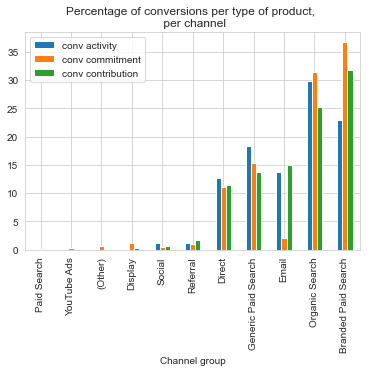

In [ ]:
c.plot(x='Channel group', y=['conv activity', 'conv commitment', 'conv contribution'], kind="bar")
plt.title('Percentage of conversions per type of product, \n per channel')
plt.legend() 
plt.show()

In [ ]:
df_merged_transactions.groupby('reference_type').sum('Transaction revenue')

,Users,Transactions,Transaction revenue,contact_number,lts,age,Total time on site,Pageviews,hour
reference_type,,,,,,,,,
Activity,87,87,5940.8,4.364109e+09,52200.44,4825.0,91401,2516,1211
Commitment,824,824,172935.0,4.085433e+10,718014.66,52091.0,614134,9548,12027
Contribution,5282,5282,706795.1,2.507458e+11,5708535.57,298924.0,2813157,58226,72863


In [ ]:
# repeat results for revenue 
# Table of transactions per channel group and reference type 
test1 = df_merged_transactions_grouped_by_type2[['Channel group', 'reference_type', 'Transaction revenue']]
c2 = pd.pivot_table(data=test1, 
                        index=['Channel group'], 
                        columns=['reference_type'], 
                        values='Transaction revenue') 
revenue_activity = 5940.8
revenue_commitments = 172935.0
revenue_contributions = 706795.1
c2['rev activity'] = round(c2['Activity'] / revenue_activity * 100, 2)
c2['rev commitment'] = round(c2['Commitment'] / revenue_commitments * 100,2)
c2['rev contribution'] = round(c2['Contribution'] / revenue_contributions *100,2)
print(c2)
c2 = c2.reset_index()
c2 = c2.sort_values('')

reference_type       Activity  Commitment  Contribution  rev activity  \
Channel group                                                           
(Other)                   NaN      1056.0        575.00           NaN   
Branded Paid Search    1445.6     61815.0     259697.09         24.33   
Direct                 1360.0     19572.0      91763.12         22.89   
Display                   NaN      1866.0        700.50           NaN   
Email                   742.0      3600.0      77743.96         12.49   
Generic Paid Search     696.8     25584.0      55993.88         11.73   
Organic Search         1619.0     56130.0     208551.15         27.25   
Paid Search               NaN       210.0           NaN           NaN   
Referral                 62.4      1782.0      10070.40          1.05   
Social                   15.0       870.0       1665.00          0.25   
YouTube Ads               NaN       450.0         35.00           NaN   

reference_type       rev commitment  rev contribut

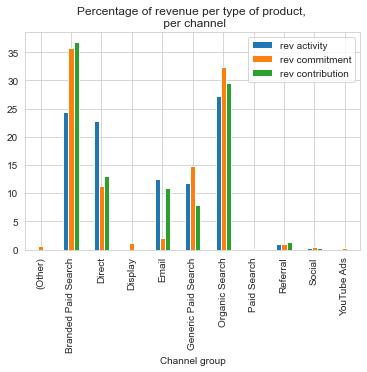

In [ ]:
c2.plot(x='Channel group', y=['rev activity', 'rev commitment', 'rev contribution'], kind="bar")
plt.title('Percentage of revenue per type of product, \n per channel')
plt.legend() 
plt.show()

In [ ]:
# check reference_type - type of transaction 
print(df_merged_transactions['reference_type'].value_counts())
df_merged_transactions_grouped_by_type = df_merged_transactions[['Date', 'reference_type', 'Users', 'Transactions', 'Transaction revenue', 'Total time on site', 'Pageviews']]
df_merged_transactions_grouped_by_type = df_merged_transactions_grouped_by_type.groupby(['Date', 'reference_type']).sum()
df_merged_transactions_grouped_by_type

Contribution    5282
Commitment       824
Activity          87
Name: reference_type, dtype: int64


Users  Transactions  Transaction revenue  \
Date       reference_type                                             
2021-01-01 Commitment          6             6              1326.00   
           Contribution       28            28              3558.90   
2021-01-02 Commitment         13            13              2412.00   
           Contribution       33            33             22380.00   
2021-01-03 Activity            2             2                62.40   
...                          ...           ...                  ...   
2021-12-29 Contribution       64            64             13020.00   
2021-12-30 Commitment          2             2               372.00   
           Contribution       68            68             11360.00   
2021-12-31 Commitment          2             2               396.00   
           Contribution       77            77              9756.65   

                           Total time on site  Pageviews  
Date       reference_type                                 
2021-01-01 Commitment                    6427        101  
           Contribution                 15896        204  
2021-01-02 Commitment                    8059        128  
           Contribution                 16525        271  
2021-01-03 Activity                      1543         74  
...                                       ...        ...  
2021-12-29 Contribution                 29808        569  
2021-12-30 Commitment                    1892         29  
           Contribution                 33395        567  
2021-12-31 Commitment                    2064         43  
           Contribution                 32552        613  

[716 rows x 5 columns]

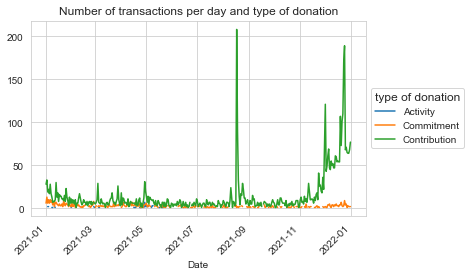

In [ ]:
# plot results 
df_merged_transactions_grouped_by_type.unstack()['Transactions'].plot()
plt.legend(title='type of donation',title_fontsize=12,loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45)
plt.title('Number of transactions per day and type of donation')
plt.show()

Transaction revenue follows now the same pattern as the transaction number, which makes sense

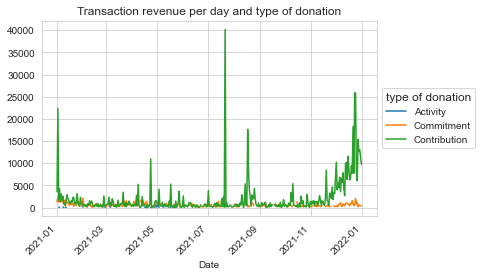

In [ ]:
# plot results 
df_merged_transactions_grouped_by_type.unstack()['Transaction revenue'].plot()
plt.legend(title='type of donation',title_fontsize=12,loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45)
plt.title('Transaction revenue per day and type of donation')
plt.show()

The excesive (and unexpected) transaction revenues on 01.02.2021 and 24.02.2021 are caused by two entry errors, see clientIDs 676908493.1607510701 (01.02) and 97296655.1614192922 (24.02). 
In reality, it seems like the revenue for commitments is calculated as monthly payment * 6 

**Issue already corrected, this are just tests done to find the error**

In [1352]:
# check normal contribution cases I 
df_merged_transactions[df_merged_transactions['clientID'] == '39565.1609585172']['Transaction revenue'] # 35
df_merged_transactions[df_merged_transactions['clientID'] == '39565.1609585172']['contact_number'] #  ok

0    51789550.0
Name: contact_number, dtype: float64

In [1353]:
# check normal contribution cases II 
df_merged_transactions[df_merged_transactions['clientID'] == '1197085.1609745532']['Transaction revenue'] # 15
df_merged_transactions[df_merged_transactions['clientID'] == '1197085.1609745532']['contact_number'] #  ok 

1    51794998.0
Name: contact_number, dtype: float64

In [1354]:
# check contributions on 2021-07-21 - real one 
df_merged_transactions[df_merged_transactions['Date'] == '2021-07-21'][['clientID', 'Transaction revenue']]
df_merged_transactions[df_merged_transactions['clientID'] == '110577743.1626854712']['Transaction revenue'] # 40000€
df_merged_transactions[df_merged_transactions['clientID'] == '110577743.1626854712']['contact_number'] # 51893733

2313    51893733.0
Name: contact_number, dtype: float64

In [1355]:
# check contributions on 2021-04-23 - real one 
df_merged_transactions[df_merged_transactions['Date'] == '2021-04-23'][['clientID', 'Transaction revenue']]
df_merged_transactions[df_merged_transactions['clientID'] == '655658896.1605273119']['Transaction revenue'] # 10000€
df_merged_transactions[df_merged_transactions['clientID'] == '655658896.1605273119']['contact_number'] # 51664894

637    51664894.0
Name: contact_number, dtype: float64

In [1356]:
# check normal commitment cases I
df_merged_transactions[df_merged_transactions['clientID'] == '2027477.1617603152']['Transaction revenue'] # 210 
df_merged_transactions[df_merged_transactions['clientID'] == '2027477.1617603152']['contact_number'] #  35€ month 

2    51849586.0
Name: contact_number, dtype: float64

In [1357]:
# check normal commitment cases II
df_merged_transactions[df_merged_transactions['clientID'] == '4820105.1611613176']['Transaction revenue'] # 300
df_merged_transactions[df_merged_transactions['clientID'] == '4820105.1611613176']['contact_number'] # 50€ month, 6 months 

4    51830636.0
Name: contact_number, dtype: float64

Commitment on 2021-02-01 for clientID 676908493.1607510701 was checked internally and found to be an entry error. It was then substituted for what it seems to be considered as the "real" value (monthly payment * 6)

In [ ]:
# check commitments on 2021-02-01 
# df_merged_transactions[df_merged_transactions['Date'] == '2021-02-01']
# df_merged_transactions[df_merged_transactions['clientID'] == '4820105.1611613176']['Transaction revenue']
# df_merged_transactions[df_merged_transactions['clientID'] == '530625557.1612210254']['Transaction revenue']
df_merged_transactions[df_merged_transactions['clientID'] == '676908493.1607510701']['Transaction revenue'] # 100€ per month, 600€ revenue 
# substitute with real value 


656    60210.0
Name: Transaction revenue, dtype: float64

In [ ]:
df_merged_transactions[df_merged_transactions['clientID'] == '97296655.1614192922']['Transaction revenue'] # 35€ month, 210€ revenue 

88    60210.0
Name: Transaction revenue, dtype: float64

In [ ]:
# check commitments per channel 
df_channel_internal = df_merged_transactions[['Date', 'Channel group', 'reference_type', 'Transactions']]
df_grouped_by_channel_internal= df_channel_internal.groupby(['Date', 'Channel group']).sum()
df_grouped_by_channel_internal

Transactions
Date       Channel group                    
2021-01-01 Branded Paid Search            11
           Direct                          5
           Email                           1
           Generic Paid Search             8
           Organic Search                  8
...                                      ...
2021-12-30 Organic Search                 26
2021-12-31 Branded Paid Search            25
           Direct                         16
           Email                           9
           Organic Search                 29

[1404 rows x 1 columns]

Same pattern as before, this gives no new info

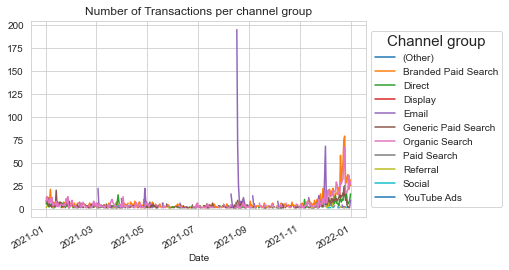

In [ ]:
df_grouped_by_channel_internal.unstack()['Transactions'].plot()
plt.legend(title='Channel group',title_fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of Transactions per channel group')
plt.show()

In [1358]:
# create feature of new_donor if start date contact == transaction date 
df_merged_transactions['new_donor'] = np.where(df_merged_transactions['Date'] == df_merged_transactions['startdate_contact'], 'new_donor_yes', 'new_donor_no')
df_merged_transactions['new_donor'].value_counts()

new_donor_no     3101
new_donor_yes    3092
Name: new_donor, dtype: int64

In [1359]:
test1 = df_merged_transactions[['new_donor', 'Channel group', 'Transactions']].groupby(['new_donor', 'Channel group']).sum() # .reset_index()
# test1
new_donor_yes = 3092
new_donor_no = 3101
# pivot table 
c3 = pd.pivot_table(data=test1, 
                    index=['Channel group'], 
                    columns=['new_donor'], 
                    values='Transactions') 
c3['channel perc for new donors'] = round(c3['new_donor_yes'] / new_donor_yes * 100,3)
c3['channel perc for old donors'] = round(c3['new_donor_no'] / new_donor_no * 100,3)
c3 = c3.reset_index()
c3

new_donor,Channel group,new_donor_no,new_donor_yes,channel perc for new donors,channel perc for old donors
0,(Other),10.0,3.0,0.097,0.322
1,Branded Paid Search,1024.0,978.0,31.630,33.022
2,Direct,346.0,364.0,11.772,11.158
3,Display,12.0,10.0,0.323,0.387
4,Email,798.0,26.0,0.841,25.734
5,Generic Paid Search,167.0,704.0,22.768,5.385
6,Organic Search,694.0,919.0,29.722,22.380
7,Paid Search,1.0,NaN,NaN,0.032
8,Referral,38.0,59.0,1.908,1.225
9,Social,10.0,27.0,0.873,0.322


In [1360]:
print(c3[['Channel group', 'channel perc for new donors', 'channel perc for old donors']].to_latex())

\begin{tabular}{llrr}
\toprule
new\_donor &        Channel group &  channel perc for new donors &  channel perc for old donors \\
\midrule
0  &              (Other) &                        0.097 &                        0.322 \\
1  &  Branded Paid Search &                       31.630 &                       33.022 \\
2  &               Direct &                       11.772 &                       11.158 \\
3  &              Display &                        0.323 &                        0.387 \\
4  &                Email &                        0.841 &                       25.734 \\
5  &  Generic Paid Search &                       22.768 &                        5.385 \\
6  &       Organic Search &                       29.722 &                       22.380 \\
7  &          Paid Search &                          NaN &                        0.032 \\
8  &             Referral &                        1.908 &                        1.225 \\
9  &               Social &               

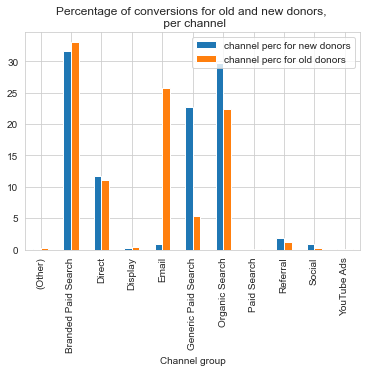

In [ ]:
c3.plot(x='Channel group', y=['channel perc for new donors', 'channel perc for old donors'], kind="bar")
plt.title('Percentage of conversions for old and new donors, \n per channel')
plt.legend() 
plt.show()

In [1361]:
# Profile depending on type of contribution (age, gender, new_donor) 
test1 = df_merged_transactions[['clientID', 'Channel group', 'Device category', 'Operating system', 'reference_type', 'gender', 'age', 'new_donor']]
test1

,clientID,Channel group,Device category,Operating system,reference_type,gender,age,new_donor
0,39565.1609585172,Referral,desktop,Windows,Contribution,m,43.0,new_donor_yes
1,1197085.1609745532,Generic Paid Search,desktop,Windows,Contribution,w,81.0,new_donor_yes
2,2027477.1617603152,Branded Paid Search,desktop,Chrome OS,Commitment,m,70.0,new_donor_yes
3,4329912.1609958594,Organic Search,desktop,Windows,Contribution,w,65.0,new_donor_no
4,4820105.1611613176,Generic Paid Search,desktop,Windows,Commitment,w,82.0,new_donor_yes
...,...,...,...,...,...,...,...,...
6188,2144281427.1640776175,Organic Search,desktop,Macintosh,Contribution,unknown,NaN,new_donor_yes
6189,2144862116.1625345225,Generic Paid Search,desktop,Windows,Contribution,w,NaN,new_donor_yes
6190,2145723571.1638087782,Branded Paid Search,desktop,Windows,Contribution,m,60.0,new_donor_no
6191,2146537263.1628511418,Direct,desktop,Macintosh,Contribution,m,50.0,new_donor_no


In [1362]:
print('Age median for new attracted donors:', test1[test1['new_donor'] == 'new_donor_yes']['age'].median())
print('Age mean for new attracted donors:', test1[test1['new_donor'] == 'new_donor_yes']['age'].median())
print('Age median for donors already existing in the dataset:', test1[test1['new_donor'] == 'new_donor_no']['age'].median())
print('Age mean for donors already existing in the dataset:', test1[test1['new_donor'] == 'new_donor_no']['age'].median())

Age median for new attracted donors: 80.0
Age mean for new attracted donors: 80.0
Age median for donors already existing in the dataset: 68.0
Age mean for donors already existing in the dataset: 68.0


In [1364]:
print(test1.age.median()) # 74
print(test1.age.mean()) # 72

74.0
72.11998378597487


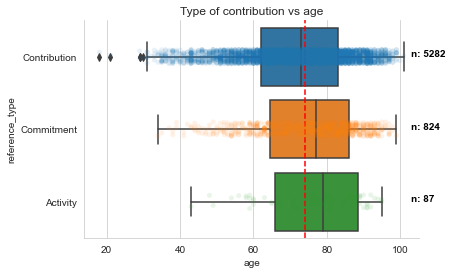

In [1365]:
max_vector = test1.groupby(['Operating system'])['age'].max()
# reorder vector 
# order_to_plot = ['Windows', 'iOS', 'Macintosh', 'Android', 'Chrome OS', 'Linux'] # extracted after plotting it once 
# max_vector = max_vector[order_to_plot]
nobs = test1['reference_type'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

# boxplot of transaction revenue vs channel group 
ax= sns.boxplot(y='reference_type',x='age',data=test1)
ax = sns.stripplot(y='reference_type', x="age",data=test1, alpha = 0.1)

plt.axvline(x=74, # median transactions 
            color='red', ls = '--')
# add nobs to plot 
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(103,
            tick, 
            nobs[tick],
            horizontalalignment='left',
            color = 'black',  
            #color='b',
            weight='semibold')
plt.title('Type of contribution vs age')
sns.despine() 
plt.show()

In [1393]:
test1['Device category'].value_counts()

desktop    3504
mobile     2558
tablet      131
Name: Device category, dtype: int64

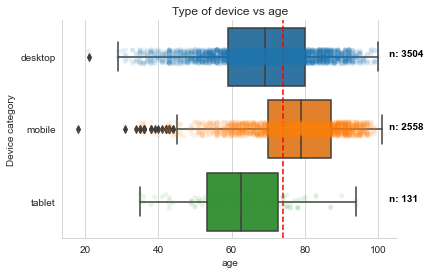

In [ ]:
# repeat for Device category 
nobs = test1['Device category'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

# boxplot of transaction revenue vs channel group 
ax= sns.boxplot(y='Device category',x='age',data=test1)
ax = sns.stripplot(y='Device category', x="age",data=test1, alpha = 0.1)

plt.axvline(x=74, # median age  
            color='red', ls = '--')
# add nobs to plot 
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(103,
            tick, 
            nobs[tick],
            horizontalalignment='left',
            color = 'black',  
            #color='b',
            weight='semibold')
plt.title('Type of device vs age')
sns.despine() 
plt.show()

In [1372]:
test1['Channel group'].value_counts()

Branded Paid Search    2002
Organic Search         1613
Generic Paid Search     871
Email                   824
Direct                  710
Referral                 97
Social                   37
Display                  22
(Other)                  13
YouTube Ads               3
Paid Search               1
Name: Channel group, dtype: int64

In [1395]:
nobs = test1['Channel group'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
nobs

['n: 2002',
 'n: 1613',
 'n: 871',
 'n: 824',
 'n: 710',
 'n: 97',
 'n: 37',
 'n: 22',
 'n: 13',
 'n: 3',
 'n: 1']

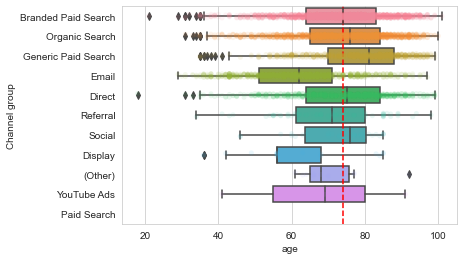

In [1397]:
# boxplot of transaction revenue vs channel group 
ax= sns.boxplot(y='Channel group',x='age',data=test1, order = order_to_plot)
ax = sns.stripplot(y='Channel group', x="age",data=test1, alpha = 0.1, order = order_to_plot)
plt.axvline(x=74, # median age  
            color='red', ls = '--')

In [1398]:
pos = range(len(nobs))
pos

range(0, 11)

In [1408]:
for tick,label in zip(range(0,11),ax.get_yticklabels()):
    print(nobs[tick])
    print(label)
    

n: 2002
Text(0, 0, 'Branded Paid Search')
n: 1613
Text(0, 1, 'Organic Search')
n: 871
Text(0, 2, 'Generic Paid Search')
n: 824
Text(0, 3, 'Email')
n: 710
Text(0, 4, 'Direct')
n: 97
Text(0, 5, 'Referral')
n: 37
Text(0, 6, 'Social')
n: 22
Text(0, 7, 'Display')
n: 13
Text(0, 8, '(Other)')
n: 3
Text(0, 9, 'YouTube Ads')
n: 1
Text(0, 10, 'Paid Search')


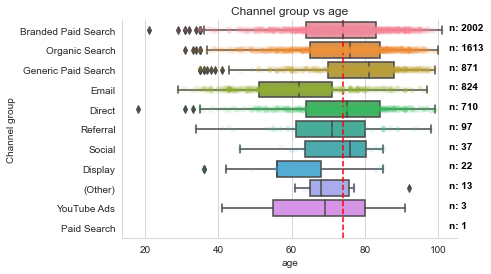

In [1409]:
# repeat for channel group 
nobs = test1['Channel group'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
# nobs

# boxplot of transaction revenue vs channel group 
ax= sns.boxplot(y='Channel group',x='age',data=test1, order = order_to_plot)
ax = sns.stripplot(y='Channel group', x="age",data=test1, alpha = 0.1, order = order_to_plot)

plt.axvline(x=74, # median age  
            color='red', ls = '--')
# add nobs to plot 
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_yticklabels()):
    ax.text(103,
            tick, 
            nobs[tick],
            horizontalalignment='left',
            color = 'black',  
            #color='b',
            weight='semibold')

plt.title('Channel group vs age')
sns.despine() 
plt.show()

In [1410]:
# check gender 
df_merged_transactions.gender.value_counts()

w          2970
m          2913
unknown     310
Name: gender, dtype: int64

In [1411]:
df_merged_transactions[['gender', 'new_donor']].value_counts()

gender   new_donor    
m        new_donor_no     1666
w        new_donor_yes    1640
         new_donor_no     1330
m        new_donor_yes    1247
unknown  new_donor_yes     205
         new_donor_no      105
dtype: int64

In [1412]:
df_merged_transactions[['gender', 'reference_type']].value_counts()

gender   reference_type
m        Contribution      2555
w        Contribution      2461
         Commitment         457
m        Commitment         327
unknown  Contribution       266
w        Activity            52
unknown  Commitment          40
m        Activity            31
unknown  Activity             4
dtype: int64

In [ ]:
df_merged_transactions[['gender', 'reference_type', 'new_donor']].value_counts()

gender   reference_type  new_donor    
m        Contribution    new_donor_no     1534
w        Contribution    new_donor_yes    1280
                         new_donor_no     1181
m        Contribution    new_donor_yes    1021
w        Commitment      new_donor_yes     327
m        Commitment      new_donor_yes     206
unknown  Contribution    new_donor_yes     169
w        Commitment      new_donor_no      130
m        Commitment      new_donor_no      121
unknown  Contribution    new_donor_no       97
w        Activity        new_donor_yes      33
unknown  Commitment      new_donor_yes      33
m        Activity        new_donor_yes      20
w        Activity        new_donor_no       19
m        Activity        new_donor_no       11
unknown  Commitment      new_donor_no        7
         Activity        new_donor_yes       3
                         new_donor_no        1
dtype: int64

In [1413]:
df_merged_transactions_women = df_merged_transactions[df_merged_transactions['gender'] == 'w']
df_merged_transactions_men = df_merged_transactions[df_merged_transactions['gender'] == 'm']
df_merged_transactions_unknown = df_merged_transactions[df_merged_transactions['gender'] == 'unknown']

print('Median age men: ', df_merged_transactions_men['age'].median())
print('Median age women: ', df_merged_transactions_women['age'].median())
print('Median age unknwown: ', df_merged_transactions_unknown['age'].median())

Median age men:  71.0
Median age women:  77.0
Median age unknwown:  72.0


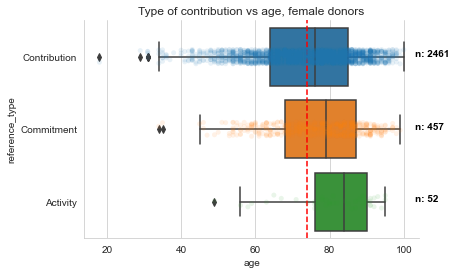

In [1414]:
# order_to_plot = ['Windows', 'iOS', 'Macintosh', 'Android', 'Chrome OS', 'Linux'] # extracted after plotting it once 
# max_vector = max_vector[order_to_plot]
nobs = df_merged_transactions_women['reference_type'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

# boxplot of transaction revenue vs channel group 
ax= sns.boxplot(y='reference_type',x='age',data=df_merged_transactions_women)
ax = sns.stripplot(y='reference_type', x="age",data=df_merged_transactions_women, alpha = 0.1)

plt.axvline(x=74, # median transactions 
            color='red', ls = '--')
# add nobs to plot 
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(103,
            tick, 
            nobs[tick],
            horizontalalignment='left',
            color = 'black',  
            #color='b',
            weight='semibold')
plt.title('Type of contribution vs age, female donors')
sns.despine() 
plt.show()

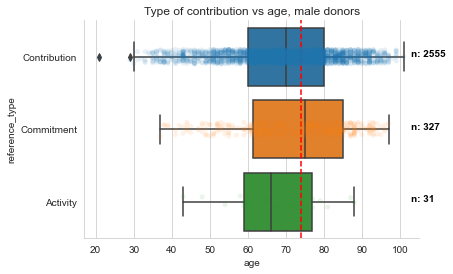

In [1415]:
# order_to_plot = ['Windows', 'iOS', 'Macintosh', 'Android', 'Chrome OS', 'Linux'] # extracted after plotting it once 
# max_vector = max_vector[order_to_plot]
nobs = df_merged_transactions_men['reference_type'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

# boxplot of transaction revenue vs channel group 
ax= sns.boxplot(y='reference_type',x='age',data=df_merged_transactions_men)
ax = sns.stripplot(y='reference_type', x="age",data=df_merged_transactions_men, alpha = 0.1)

plt.axvline(x=74, # median transactions 
            color='red', ls = '--')
# add nobs to plot 
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(103,
            tick, 
            nobs[tick],
            horizontalalignment='left',
            color = 'black',  
            #color='b',
            weight='semibold')
plt.title('Type of contribution vs age, male donors')
sns.despine() 
plt.show()

In [ ]:
# drop info - we want to keep those from df_eda 
# df_merged_transactions.drop('Transaction revenue', axis = 1, inplace = True)
# df_merged_transactions.drop('Transaction ID', axis = 1, inplace = True)
# df_merged_transactions.drop('Hour', axis = 1, inplace = True)
# df_merged_transactions.drop('Minute', axis = 1, inplace = True)

In [ ]:
# merge with selected features of df_eda 
# df_merged_transactions = pd.merge(left = df_merged_transactions, right = df_eda[['clientID', 'Date', 'Channel group', 'Total time on site', 'Pageviews', 'Transaction revenue', 'weekday', 'hour']], how = 'left', on = ['clientID', 'Date', 'Channel group'])

In [ ]:
# df_merged_transactions_grouped_by_type = df_merged_transactions_grouped_by_type.reset_index()
# grid = sns.FacetGrid(df_merged_transactions_grouped_by_type, col = 'reference_type', col_wrap = 3)
# grid.map(sns.lineplot, 'Date', 'Users')

#### Focus: table of paths

`df_model`

In [1416]:
df_model = df_model[['clientID', 'path_counter', 'touchpoints_number', 'Transactions', 'Transaction revenue', 'Channel group']]
# modify column name of Channel group (because they indicate path)
df_model.rename({'Channel group':'path'}, axis = 1, inplace = True)

# check number of unique clientIDs 
print(df_model['clientID'].nunique()) # 329906

329906


ONGOING. Evtl add table with review of touchpoint number vs transactions, revenue, etc. See example on "steps" file

In [1417]:
# pd.set_option('display.max_rows', 1000)

# create table per number of touchpoints 
table_of_touchpoints = df_model['touchpoints_number'].value_counts().to_frame().reset_index()
table_of_touchpoints.rename({'index':'touchpoints_number', 'touchpoints_number':'paths_number'}, axis = 1, inplace = True)
# order by counts 
table_of_touchpoints = table_of_touchpoints.sort_values('touchpoints_number', ascending = True)
table_of_touchpoints

# check 
# df_model[df_model['touchpoints_number'] == 2] 

,touchpoints_number,paths_number
0,1,274925
1,2,38296
2,3,9322
3,4,3502
4,5,1682
5,6,863
6,7,530
7,8,323
8,9,243
9,10,165


In [ ]:
# check number of unique clientIDs 
print(df_model['clientID'].nunique()) # 329906

329906


In [ ]:
# Check number of touchpoints vs transactions 
test1 = df_model[['touchpoints_number', 'Transactions', 'Transaction revenue']].groupby(['touchpoints_number']).sum().reset_index()
table_of_touchpoints = pd.merge(test1, table_of_touchpoints, on = 'touchpoints_number', how = 'left')

# add other features 
table_of_touchpoints['Transactions per path'] = table_of_touchpoints['Transactions'] / table_of_touchpoints['paths_number']
table_of_touchpoints['Revenue per path'] = table_of_touchpoints['Transaction revenue'] / table_of_touchpoints['paths_number']
table_of_touchpoints['Path percentage'] = table_of_touchpoints['paths_number'] / table_of_touchpoints['paths_number'].sum()


In [ ]:
table_of_touchpoints.sort_values('paths_number', ascending = False)

,touchpoints_number,Transactions,Transaction revenue,paths_number,Transactions per path,Revenue per path,Path percentage
0,1,4979,775454.84,274925,0.018110,2.820605,0.831831
1,2,1102,162077.79,38296,0.028776,4.232238,0.115871
2,3,261,114405.32,9322,0.027998,12.272615,0.028205
3,4,96,10376.00,3502,0.027413,2.962878,0.010596
4,5,25,3548.65,1682,0.014863,2.109780,0.005089
5,6,17,3317.00,863,0.019699,3.843569,0.002611
6,7,10,1459.00,530,0.018868,2.752830,0.001604
7,8,9,2158.00,323,0.027864,6.681115,0.000977
8,9,1,240.00,243,0.004115,0.987654,0.000735
9,10,1,210.00,165,0.006061,1.272727,0.000499


In [ ]:
# add "1" to each row, so that we can sum them up 
df_model['number_of_paths'] = 1

# create table of paths 
table_of_paths = df_model[['path', 'number_of_paths', 'Transactions', 'Transaction revenue']].groupby(['path']).sum()
table_of_paths = table_of_paths.reset_index() 
table_of_paths = table_of_paths.sort_values('number_of_paths', ascending = False)

In [ ]:
# add some features 
table_of_paths['Transactions per path'] = table_of_paths['Transactions'] / table_of_paths['number_of_paths']
table_of_paths['Revenue per path'] = round(table_of_paths['Transaction revenue'] / table_of_paths['number_of_paths'],2)
table_of_paths['Path percentage'] = round(table_of_paths['number_of_paths'] / table_of_paths['number_of_paths'].sum() *100,2)
table_of_paths['Transactions percentage'] = round(table_of_paths['Transactions'] / table_of_paths['Transactions'].sum() *100,2)
table_of_paths['Transaction revenue percentage'] = round(table_of_paths['Transaction revenue'] / table_of_paths['Transaction revenue'].sum()*100, 2)
table_of_paths['Avg. revenue per transaction'] = round(table_of_paths['Transaction revenue'] /table_of_paths['Transactions'],2)

# table_of_paths = table_of_paths.sort_values('Transactions per path', ascending = False)
table_of_paths

,path,number_of_paths,Transactions,Transaction revenue,Transactions per path,Revenue per path,Path percentage,Transactions percentage,Transaction revenue percentage,Avg. revenue per transaction
1423,Organic Search,102857,1266,259802.15,0.012308,2.53,31.12,19.37,24.11,205.21
943,Display,54645,13,1450.00,0.000238,0.03,16.53,0.20,0.13,111.54
1241,Generic Paid Search,29348,687,74003.87,0.023409,2.52,8.88,10.51,6.87,107.72
495,Direct,25629,681,112096.02,0.026571,4.37,7.75,10.42,10.40,164.61
104,Branded Paid Search,23531,1574,258009.76,0.066890,10.96,7.12,24.09,23.94,163.92
...,...,...,...,...,...,...,...,...,...,...
1017,Display > Display > Display > Display > Displa...,1,0,0.00,0.000000,0.00,0.00,0.00,0.00,NaN
1016,Display > Display > Display > Display > Displa...,1,0,0.00,0.000000,0.00,0.00,0.00,0.00,NaN
1013,Display > Display > Display > Display > Displa...,1,0,0.00,0.000000,0.00,0.00,0.00,0.00,NaN
1012,Display > Display > Display > Display > Displa...,1,0,0.00,0.000000,0.00,0.00,0.00,0.00,NaN


In [ ]:
# plot 
table_of_paths_substract_first_15 = table_of_paths[0:15]
table_of_paths_substract_first_15[['path', 'number_of_paths', 'Transactions', 'Path percentage', 'Transactions percentage', 'Transaction revenue percentage', 'Avg. revenue per transaction']]

,path,number_of_paths,Transactions,Path percentage,Transactions percentage,Transaction revenue percentage,Avg. revenue per transaction
1423,Organic Search,102857,1266,31.12,19.37,24.11,205.21
943,Display,54645,13,16.53,0.20,0.13,111.54
1241,Generic Paid Search,29348,687,8.88,10.51,6.87,107.72
495,Direct,25629,681,7.75,10.42,10.40,164.61
104,Branded Paid Search,23531,1574,7.12,24.09,23.94,163.92
2397,Social,12992,24,3.93,0.37,0.16,69.92
0,(Other),9677,10,2.93,0.15,0.13,135.10
1105,Email,8056,656,2.44,10.04,5.33,87.51
1692,Organic Search > Organic Search,7999,119,2.42,1.82,2.04,185.00
959,Display > Display,7977,3,2.41,0.05,0.03,98.33


In [ ]:
pd.options.display.max_colwidth = 100

In [ ]:
# extract longer touchpoint for example for report 
table_of_paths_substract_first_100 = table_of_paths[1:100]
table_of_paths_substract_first_100 [['path', 'number_of_paths', 'Transactions', 'Path percentage', 'Transactions percentage', 'Transaction revenue percentage', 'Avg. revenue per transaction']]

In [ ]:
print(table_of_paths_substract_first_15[['path', 'number_of_paths', 'Transactions', 'Path percentage', 'Transactions percentage', 'Transaction revenue percentage', 'Avg. revenue per transaction']].to_latex())

\begin{tabular}{llrrrrrr}
\toprule
{} &                                  path &  number\_of\_paths &  Transactions &  Path percentage &  Transactions percentage &  Transaction revenue percentage &  Avg. revenue per transaction \\
\midrule
943  &                               Display &            54645 &            13 &            16.53 &                     0.20 &                            0.13 &                        111.54 \\
1241 &                   Generic Paid Search &            29348 &           687 &             8.88 &                    10.51 &                            6.87 &                        107.72 \\
495  &                                Direct &            25629 &           681 &             7.75 &                    10.42 &                           10.40 &                        164.61 \\
104  &                   Branded Paid Search &            23531 &          1574 &             7.12 &                    24.09 &                           23.94 &               

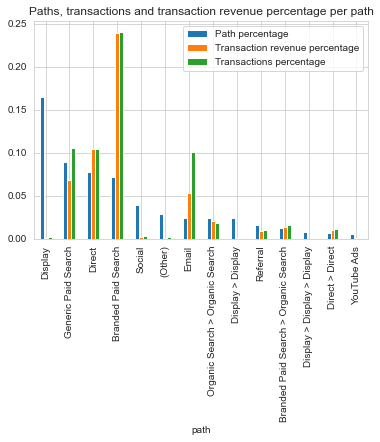

In [ ]:
# plot path vs avg. revenue per transaction 
table_of_paths_substract_first_15.plot(x='path', y=['Path percentage', 'Transaction revenue percentage', 'Transactions percentage'], kind="bar")
plt.title('Paths, transactions and transaction revenue percentage per path')
plt.legend() 
plt.show()